# Try to understand why there is missing flux when strong and weak fields are combined

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from blos_binning_helper import create_stokes_profiles, get_blos, run_cmilos, cmilos_synthesis, run_pymilos, get_blos_inst_pixel
import scipy.integrate as spi
# import milos as pym
import pymilos_5250 as pym_5
import sunpy.visualization.colormaps as cm
import matplotlib as mpl
import os
import subprocess
magmap = mpl.colormaps['hmimag']

font = {'size'   : 18}

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
def plot_diff_x(x, I_big, V_big, I, v, big_B = 2000, small_B = 100):
    print("Weight avg: ", big_B*x + (1-x)*small_B)
    comb_I = x*(I_big) + (1-x)*I
    comb_v = x*(V_big) + (1-x)*v
    comb_stokes = np.zeros((1,1,4,51))
    comb_stokes[:,:,0,:] = comb_I
    comb_stokes[:,:,3,:] = comb_v

    refwv=6173.341
    dlambda=0.35
    num_points=51
    
    waves = np.linspace(-dlambda,dlambda,num_points)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.plot(waves,I_big,label=f'{big_B}G')
    plt.plot(waves,I,label=f'{small_B}G')
    plt.plot(waves,comb_I,label=f'{1-x:.1f}*{small_B}G+{x:.1f}*{big_B}G')
    plt.legend()
    plt.ylabel('Stokes I/Ic')
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.subplot(122)
    plt.plot(waves,V_big,label=f'{big_B}G')
    plt.plot(waves,v,label=f'{small_B}G')
    plt.plot(waves,comb_v,label=f'{1-x:.1f}*{small_B}G+{x:.1f}*{big_B}G')
    plt.legend()
    plt.ylabel('Stokes V/Ic')
    plt.xlabel(r'Wavelength [$\AA$]')

In [3]:
def plot_stokes_fit(stokes,fit,y,x):
    plt.figure(figsize=(16,10))
    plt.suptitle(f'[y,x] = {[y,x]}')
    plt.subplot(121)
    plt.plot(range(51),fit[y,x,0,:],label='fit')
    plt.plot(range(51),stokes[y,x,0,:],label='original')
    plt.legend()
    plt.title("Stokes I/Ic")
    plt.subplot(122)
    plt.plot(range(51),fit[y,x,3,:],label='fit')
    plt.plot(range(51),stokes[y,x,3,:],label='original')
    plt.legend()
    plt.title("Stokes V/Ic")
    plt.tight_layout()
    plt.show()

In [4]:
int(6172.9)

6172

In [4]:
def run_new_cmilos_syn(res, wavelengths, out_dir='./', niter=15):
    res1 = res[2:-1,:,:]
    res2 = np.moveaxis(res1, 0, -1)
    res3 = np.reshape(res2, (res.shape[1]*res.shape[2],9))
    
    file_dummy_in = os.path.join(out_dir, 'dummy_in.txt')
    file_dummy_out = os.path.join(out_dir, 'dummy_out.txt')

    data = res3.flatten(order='C')
    nmodels = len(data)//9

    filename = file_dummy_in
    with open(filename,"w") as f:
        #loop in wavelength axis
        for waves in wavelengths:
            f.write('%.10f \n' % (waves) )
        #loop in input model
        iter = 0
        for model in data:
            if not(iter % 9):
                f.write('%d \n' % (iter // 9) )
            f.write('%.10f \n' % (model) )
            iter += 1

    MILOS_LOC = "/scratch/slam/sinjan/true_flux_project/"  
    if int(wavelengths[25])==6173:
        cmd = MILOS_LOC+"milos/milos/lib/milos.x"
    elif int(wavelengths[25])==5250:
        cmd = MILOS_LOC+"milos_5250/milos/lib/milos.x"

    trozo = f" {int(wavelengths.size)} {niter} {1} {1} {0} {0} {0}"
    cmd = cmd + trozo + " " + file_dummy_in + " > " + file_dummy_out

    rte_on = subprocess.call(cmd,shell=True)
    res_out = np.loadtxt(file_dummy_out)

    _ = subprocess.call(f"rm {out_dir+'dummy_out.txt'}",shell=True)
    _ = subprocess.call(f"rm {out_dir+'dummy_in.txt'}",shell=True)
    res_out = np.reshape(res_out,(nmodels,wavelengths.size,5))
    res_out = np.einsum('kij->kji',res_out)
    res_out = res_out[:,1:,:]
    return res_out.reshape(res.shape[1],res.shape[2],4,wavelengths.size)

In [5]:
def get_fitted_profiles_from_stokes(stokes, dlambda, refwv=6173.341, niter=15):
    # stokes[:,:,1,:] = 0 #set Q=0
    # stokes[:,:,2,:] = 0 #set U=0
    Ic = stokes[:,:,0,100].mean()
    stokes = stokes/Ic
    num_points = int(2*1000*dlambda/(14) + 1.0)
    stokes = stokes[:,:,:,125-int((num_points-1)/2):126+int((num_points-1)/2)]
    wavelengths = np.linspace(refwv-dlambda,refwv+dlambda,num_points)
    
    res = run_cmilos(stokes, wavelengths, "CE+RTE", options=[num_points,niter], \
                     out_dir='./', loc='cmilos_1551/', synthesis=0)
    
    return res, run_new_cmilos_syn(res, wavelengths, out_dir='./', niter=50)

In [6]:
def get_fitted_profiles_from_stokes_5250(stokes, dlambda, refwv=5250.208, niter=15):
    Ic = stokes[:,:,0,:50].mean()
    num_points = int(2*1000*dlambda/(14) + 1.0)
    wavelengths = np.linspace(refwv-dlambda,refwv+dlambda,num_points)
    stokes = stokes[:,:,:,125-int((num_points-1)/2):126+int((num_points-1)/2)]
    out = pym_5.pymilos(np.array([wavelengths.size,niter,1,0,0,0,0,0,0]), stokes/Ic, wavelengths,weight=[1,1,1,1], initial_model=[400.,30.,120.,3.,0.05,1.5,0.01,0.22,0.85], cavity=np.array([])) 
    out = out.reshape(ny,nx,12)
    out = np.moveaxis(out,-1,0)
    print(out)
    print("shape is ", out.shape)
    
    return res, run_new_cmilos_syn(out, wavelengths, out_dir='./', niter=15)        

In [7]:
def test_diff_x(x, I_big, V_big, I, v, big_B = 2000, small_B = 100, refwv=6173.341, loc = 'cmilos/'):
    #print("Weight avg: ", big_B*x + (1-x)*small_B)
    comb_I = x*(I_big) + (1-x)*I
    comb_v = x*(V_big) + (1-x)*v
    comb_stokes = np.zeros((1,1,4,51))
    comb_stokes[:,:,0,:] = comb_I
    comb_stokes[:,:,3,:] = comb_v
    avg = big_B*x + (1-x)*small_B
    dlambda=0.35
    num_points=51
    waves = np.linspace(refwv-dlambda,refwv+dlambda,num_points)
    res = run_cmilos(comb_stokes, waves, "CE+RTE", options=[51,15], \
                     out_dir='./', loc=loc, synthesis=0)
    blos = res[2,:,:]*np.cos(res[3,:,:]*np.pi/180.)
    return avg, np.mean(blos)

In [8]:
def test_diff_x_pymilos(x, stokes_big, stokes_small, big_B = 2000, small_B = 100, refwv=6173.341):
    #not normalised! and not 100:151
    #print("Weight avg: ", big_B*x + (1-x)*small_B)
    comb_stokes = x*(stokes_big) + (1-x)*stokes_small
    avg = big_B*x + (1-x)*small_B
    dlambda=0.35
    num_points=51
    waves = np.linspace(refwv-dlambda,refwv+dlambda,num_points)
    res = run_pymilos(comb_stokes, dlambda, refwv, False, weight=[1,1,1,1], \
                      initial_model=[400.,30.,120.,3.,0.05,1.5,0.01,0.22,0.85], \
                      niter=15)
    blos = res[2,:,:]*np.cos(res[3,:,:]*np.pi/180.)
    return avg, np.mean(blos)

In [9]:
ang='00'
stokes = create_stokes_profiles('ngrey_200G',ang,'200000',inst='MURaM')
blos = get_blos(stokes,0.35,6173.341,'CMILOS',False,'ngrey_200G',ang,'200000', niter=15)
res, fitted_stokes = get_fitted_profiles_from_stokes(stokes, 0.35, niter=15)
Ic = stokes[:,:,0,100].mean()

--------START---------
Folder:  ngrey_200G
Snapshot:  200000
Angle:  00
Remainder mode:  round
inst_y:  288.0
inst_x: : 288.0
-------PREP END--------
----CMILOS BLOS------
Start wv index: 100
End wv index: 151

(288, 288, 4, 51)
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_1551/


In [9]:
blos = get_blos_inst_pixel('ngrey_200G', '00', '200000', 0.35, inst='MURaM', \
                               downscale_mean=False, remainder_mode='round', refwv=6173.341, \
                               dshape=288, pixel_res=20.833333, blos_method='CMILOS', \
                               return_mean=False, default_dir="/export/local/scratch/sinjan/spinor_fwd", \
                               niter=50, ext='_1551', q_u_0 = False)
ang='00'
stokes = create_stokes_profiles('ngrey_200G',ang,'200000',inst='MURaM')
res, fitted_stokes = get_fitted_profiles_from_stokes(stokes, 0.35, niter=50)
Ic = stokes[:,:,0,100].mean()

--------START---------
Folder:  ngrey_200G
Snapshot:  200000
Angle:  00
Remainder mode:  round
inst_y:  288.0
inst_x: : 288.0
-------PREP END--------
----CMILOS BLOS------
Start wv index: 100
End wv index: 151
_1551
(288, 288, 4, 51)
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_1551/
--------START---------
Folder:  ngrey_200G
Snapshot:  200000
Angle:  00
Remainder mode:  round
inst_y:  288.0
inst_x: : 288.0
-------PREP END--------
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_1551/


## Try 1000, 1500, 2000, all together with a 100G profile from 1D
## search for low velocity

# 100G profile

In [10]:
stokes_100 = fits.getdata("/data/slam/sinjan/1d_100G_syn/6173_masi_theta00/inverted_profs.1.fits")[:,:,[0,2,3,1],:].mean(axis=(0,1))
stokes_100 = np.expand_dims(stokes_100,axis=(0,1))

In [11]:
Ic100 = stokes_100[:,:,0,100].mean(axis=(0,1))
I_100 = stokes_100[:,:,0,100:151].mean(axis=(0,1))/Ic100
V_100 = stokes_100[:,:,3,100:151].mean(axis=(0,1))/Ic100
Q_100 = stokes_100[:,:,1,100:151].mean(axis=(0,1))/Ic100
U_100 = stokes_100[:,:,2,100:151].mean(axis=(0,1))/Ic100

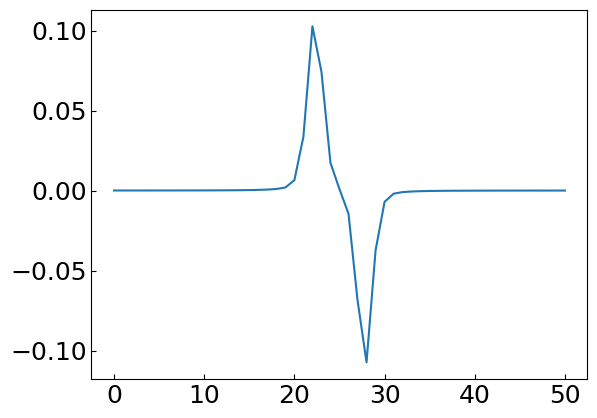

In [47]:
plt.plot(range(51),V_100)

In [12]:
refwv=6173.341
dlambda=0.35
num_points=51
wavelengths = np.linspace(refwv-dlambda,refwv+dlambda,num_points)
res_100 = run_cmilos(stokes_100[:,:,:,100:151]/Ic100, wavelengths, "CE+RTE", options=[num_points,15], \
                     out_dir='./', loc='cmilos_eqweights/', synthesis=0)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_eqweights/


In [13]:
res_100[2,:,:]*np.cos(res_100[3,:,:]/180*np.pi)

array([[99.06113477]])

In [12]:
res_100[3,:,:]

array([[1.151358]])

# 1000G

In [14]:
inc = res[3,:,:]
vel = res[6,:,:]
idx_1000G = np.where((blos>990) & (blos<1010) & (inc<0.5) & (vel < 0.03))
print(blos[idx_1000G])
print(inc[idx_1000G])
print(vel[idx_1000G])
print(idx_1000G)

[1000.12063533 1001.433297   1003.081942  ]
[3.4457e-02 2.0000e-06 4.3000e-05]
[0.026867 0.027837 0.026735]
(array([ 31,  96, 192]), array([113,  17,  66]))


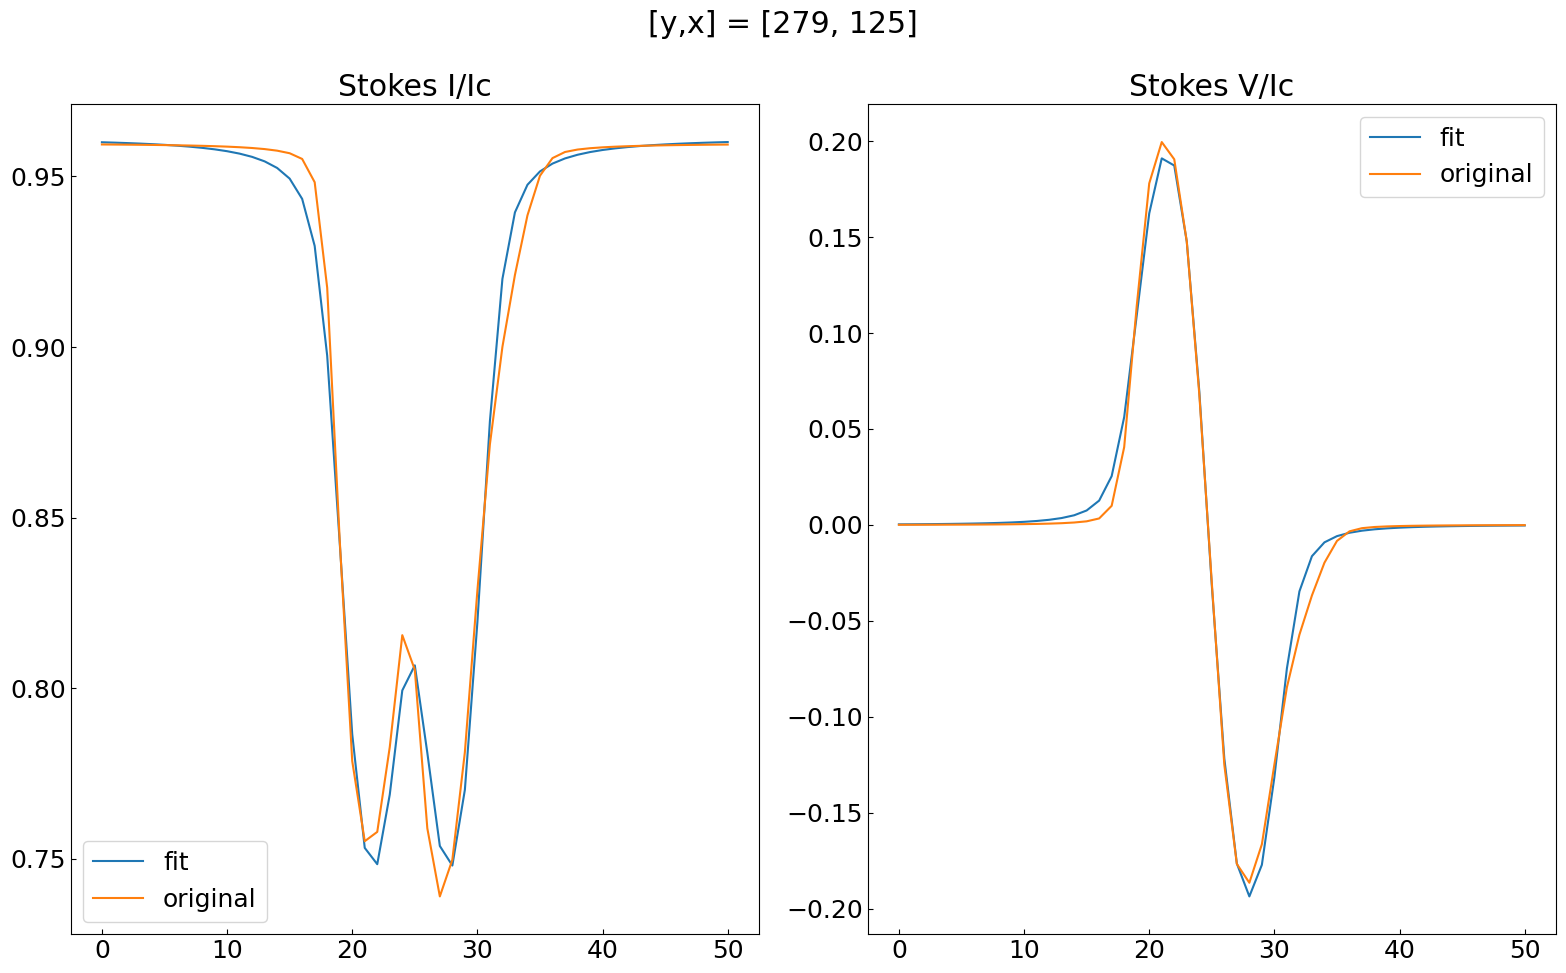

In [14]:
plot_stokes_fit(stokes[...,100:151]/Ic, fitted_stokes,279,125)

Weight avg:  549.5


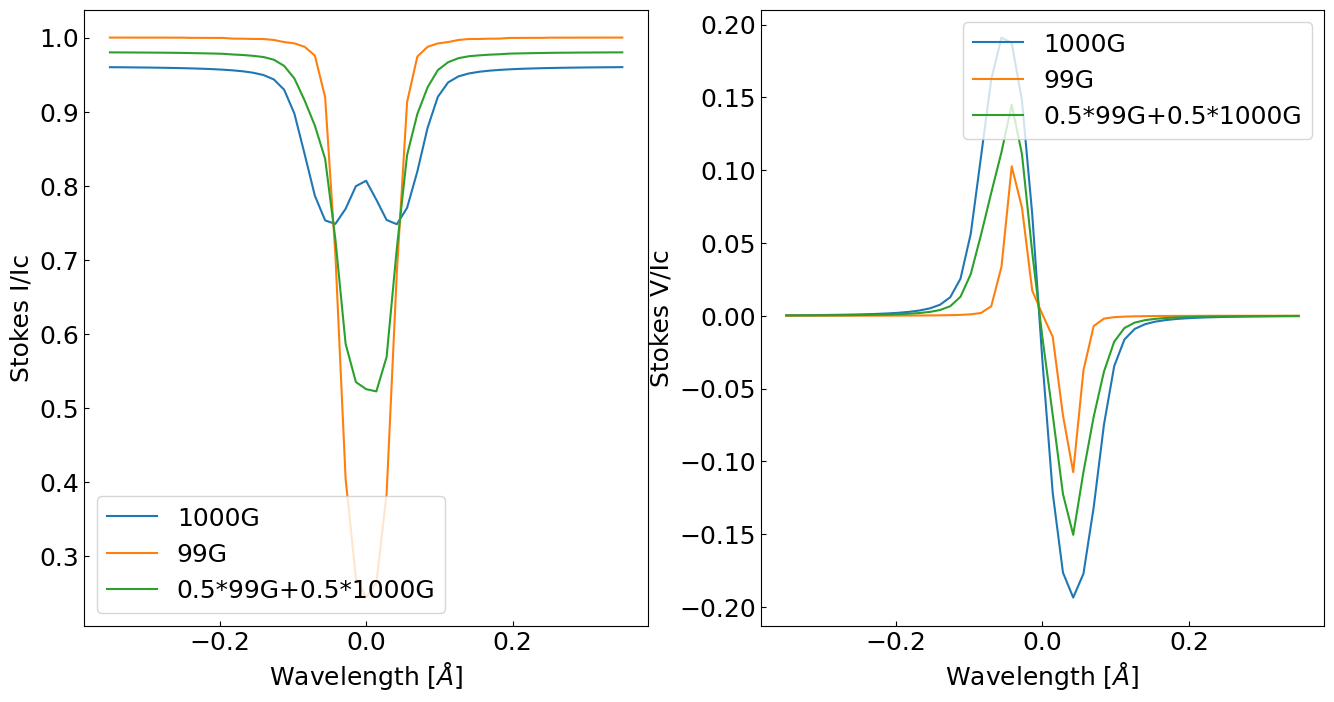

In [15]:
I_big = np.roll(fitted_stokes[279,125,0,:],0)
V_big = np.roll(fitted_stokes[279,125,3,:],0)
plot_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 1000, small_B = 99)

In [16]:
test_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 1000, small_B = 99)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


(549.5, 346.83079121351824)

In [17]:
blosl = []
weighted = []
for i in np.linspace(0,1,100):
    w,b=test_diff_x(i,I_big, V_big, I_100, V_100, big_B = 1000, small_B = 99)
    weighted.append(w)
    blosl.append(b)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/

(0.0, 1100.0)

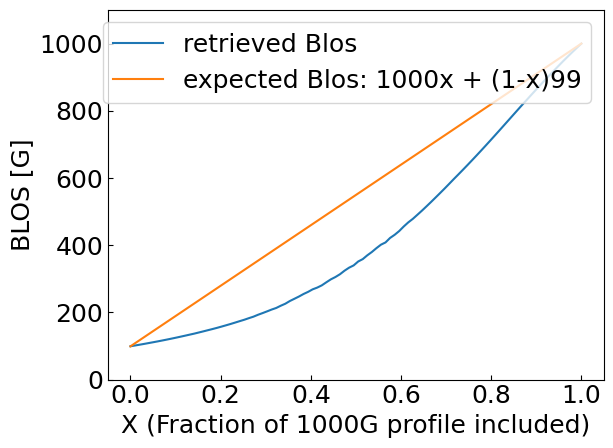

In [18]:
plt.figure()
plt.plot(np.linspace(0,1,100), blosl, label='retrieved Blos')
plt.plot(np.linspace(0,1,100), weighted, label='expected Blos: 1000x + (1-x)99')
plt.xlabel("X (Fraction of 1000G profile included)")
plt.ylabel("BLOS [G]")
plt.legend()
plt.ylim(0,1100)

# 500G

In [15]:
inc = res[3,:,:]
vel = res[6,:,:]
idx_1000G = np.where((blos>490) & (blos<510) & (inc<0.5) & (vel < 0.03))
print(blos[idx_1000G])
print(inc[idx_1000G])
print(vel[idx_1000G])
print(idx_1000G)

[493.6428461  509.08300697 494.671377  ]
[8.00000e-05 1.61749e-01 5.60000e-05]
[0.029851 0.026806 0.027289]
(array([229, 229, 253]), array([77, 78, 60]))


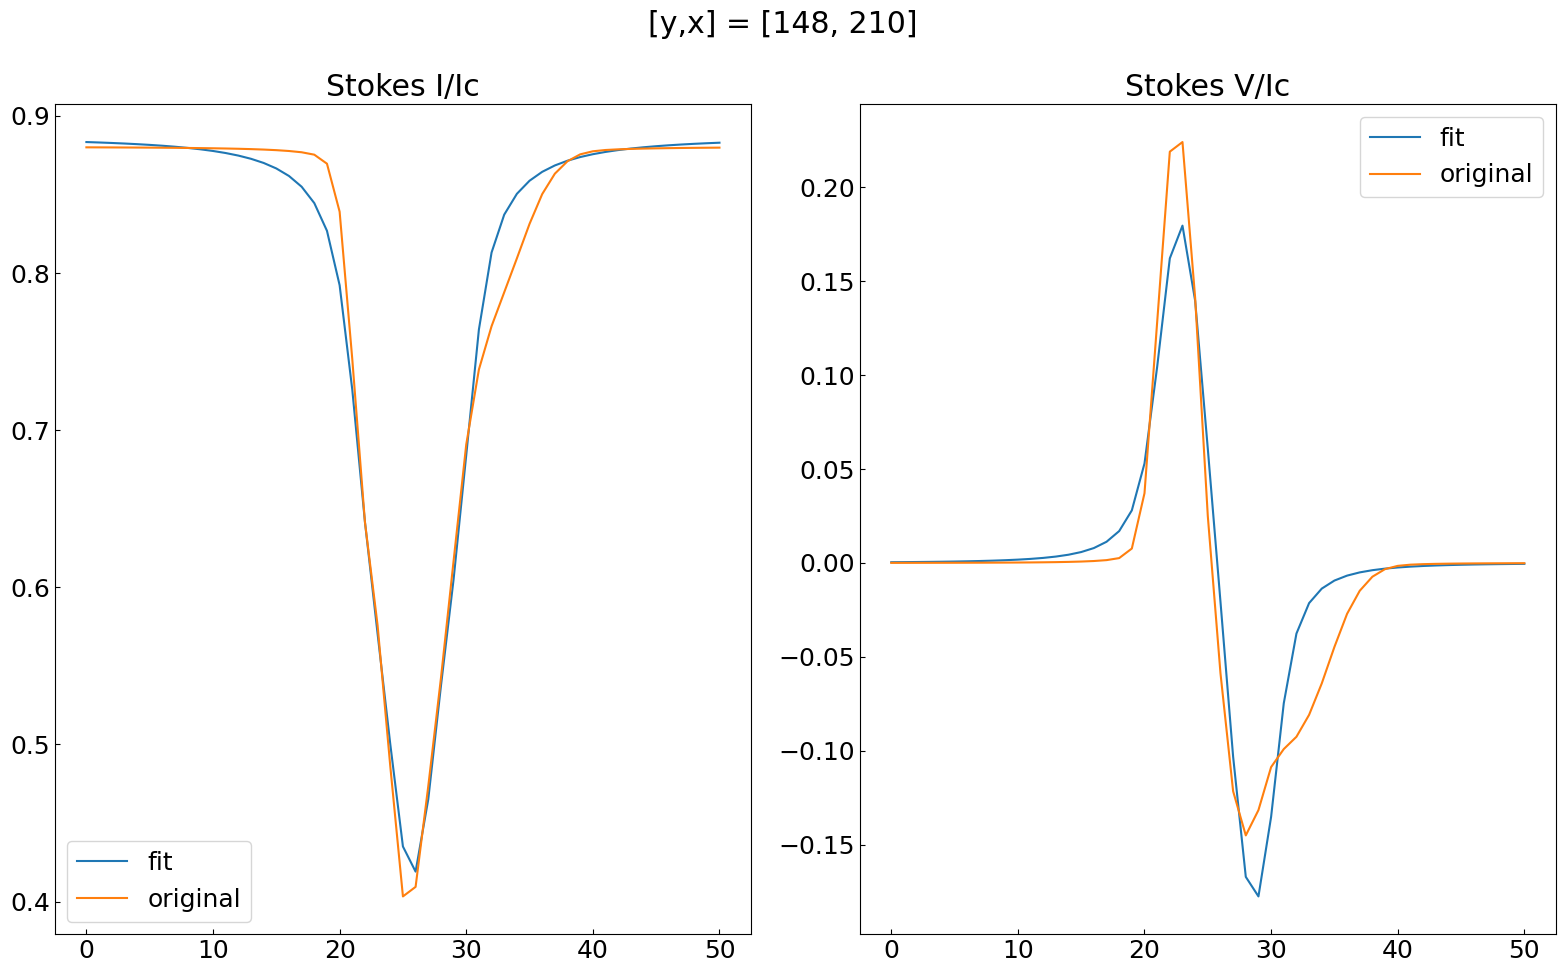

In [20]:
plot_stokes_fit(stokes[...,100:151]/Ic, fitted_stokes,148,210)

Weight avg:  296.0


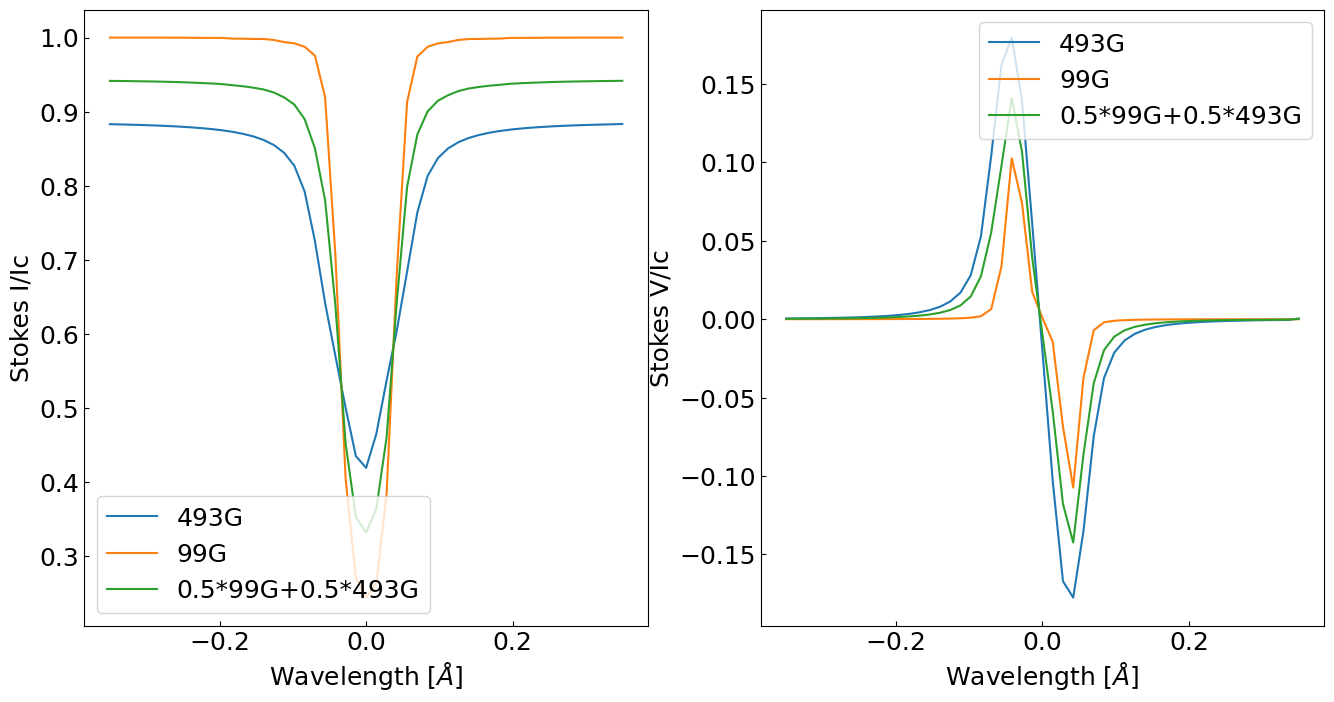

In [21]:
I_big = np.roll(fitted_stokes[148,210,0,:],-1)
V_big = np.roll(fitted_stokes[148,210,3,:],-1)
plot_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 493, small_B = 99)

In [22]:
test_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 500, small_B = 99)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


(299.5, 232.12774316796978)

In [23]:
blosl = []
weighted = []
for i in np.linspace(0,1,100):
    w,b=test_diff_x(i,I_big, V_big, I_100, V_100, big_B = 500, small_B = 99)
    weighted.append(w)
    blosl.append(b)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/

(0.0, 550.0)

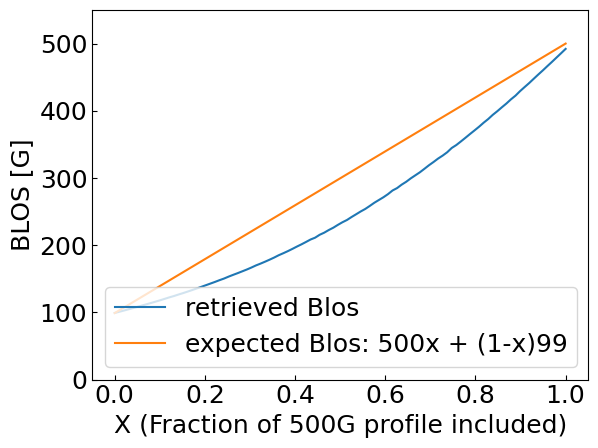

In [24]:
plt.figure()
plt.plot(np.linspace(0,1,100), blosl, label='retrieved Blos')
plt.plot(np.linspace(0,1,100), weighted, label='expected Blos: 500x + (1-x)99')
plt.xlabel("X (Fraction of 500G profile included)")
plt.ylabel("BLOS [G]")
plt.legend()
plt.ylim(0,550)

# make paper plot

- 3 panels, stokes I and V combination + fitted profile to the combined profile + 2000G profile separation?

# Combine

In [9]:
np.set_printoptions(suppress=True)

In [16]:
inc = res[3,:,:]
vel = res[6,:,:]
idx_2000G = np.where((blos>1950) & (blos<2050) & (inc<2.0) & (vel < 0.06))
print(blos[idx_2000G])
print(inc[idx_2000G])
print(vel[idx_2000G])
print(idx_2000G)

[2040.39900598 1969.731174   1988.21824791]
[1.000000e-06 8.300000e-05 1.869308e+00]
[0.033544 0.034998 0.038354]
(array([  0, 268, 287]), array([  9, 141,   8]))


In [17]:
inc = res[3,:,:]
vel = res[6,:,:]
idx_2000G = np.where((blos>1950) & (blos<2050) & (inc<1.0) & (vel < 0.05))
print(blos[idx_2000G])
print(inc[idx_2000G])
print(vel[idx_2000G])
print(idx_2000G)

[2040.39900598 1969.731174  ]
[1.0e-06 8.3e-05]
[0.033544 0.034998]
(array([  0, 268]), array([  9, 141]))


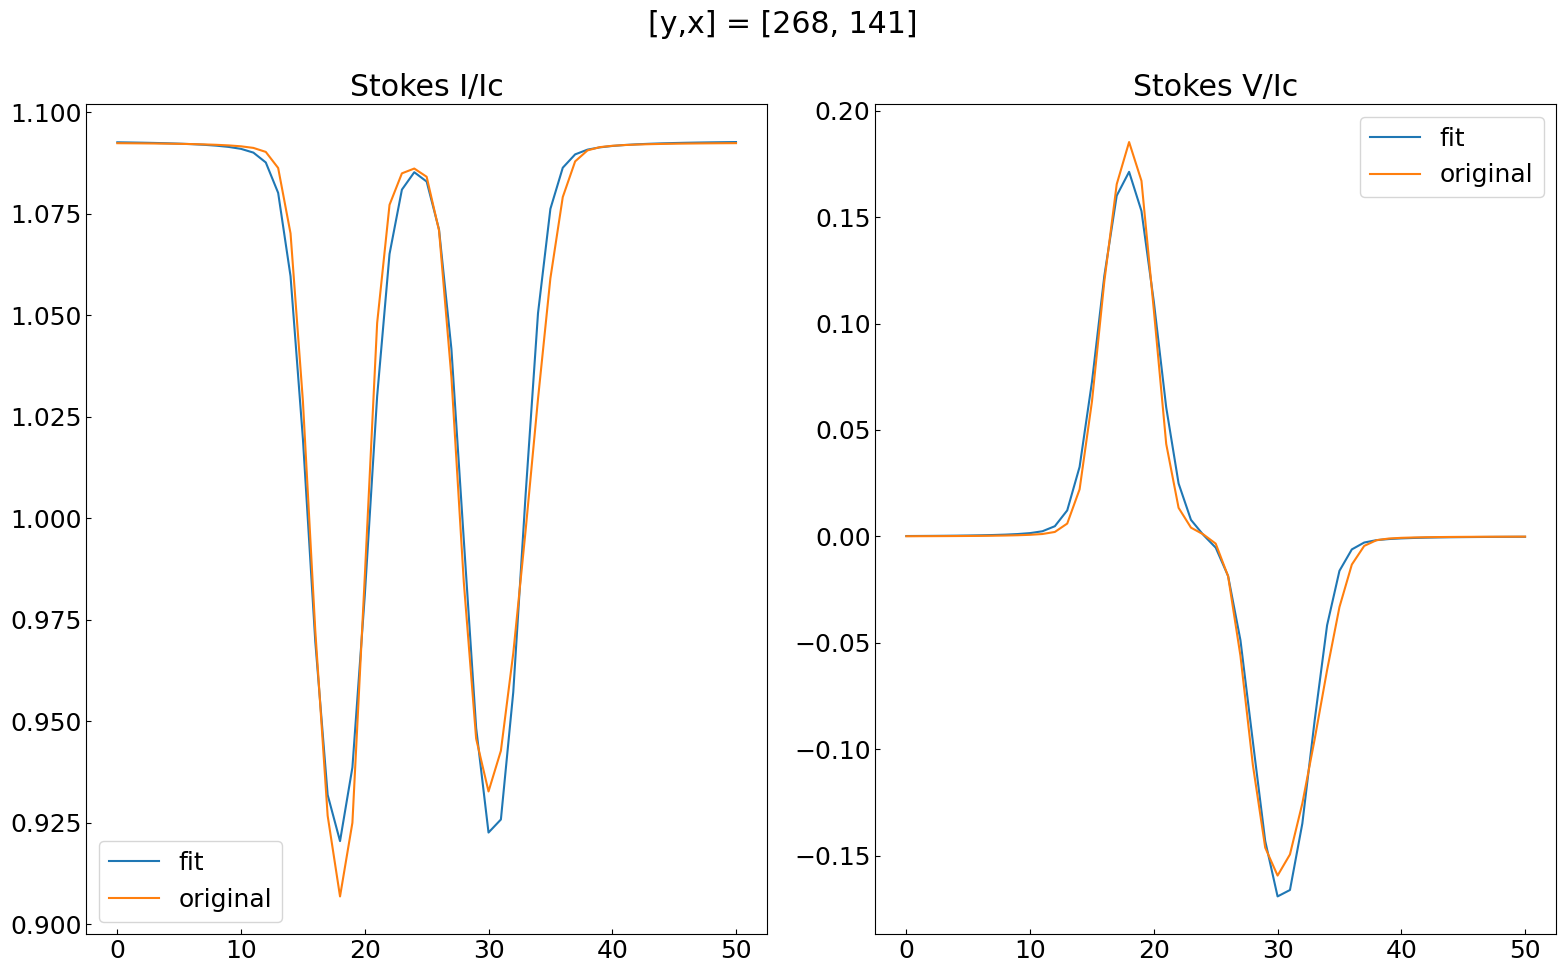

In [28]:
plot_stokes_fit(stokes[...,100:151]/Ic, fitted_stokes,268,141)

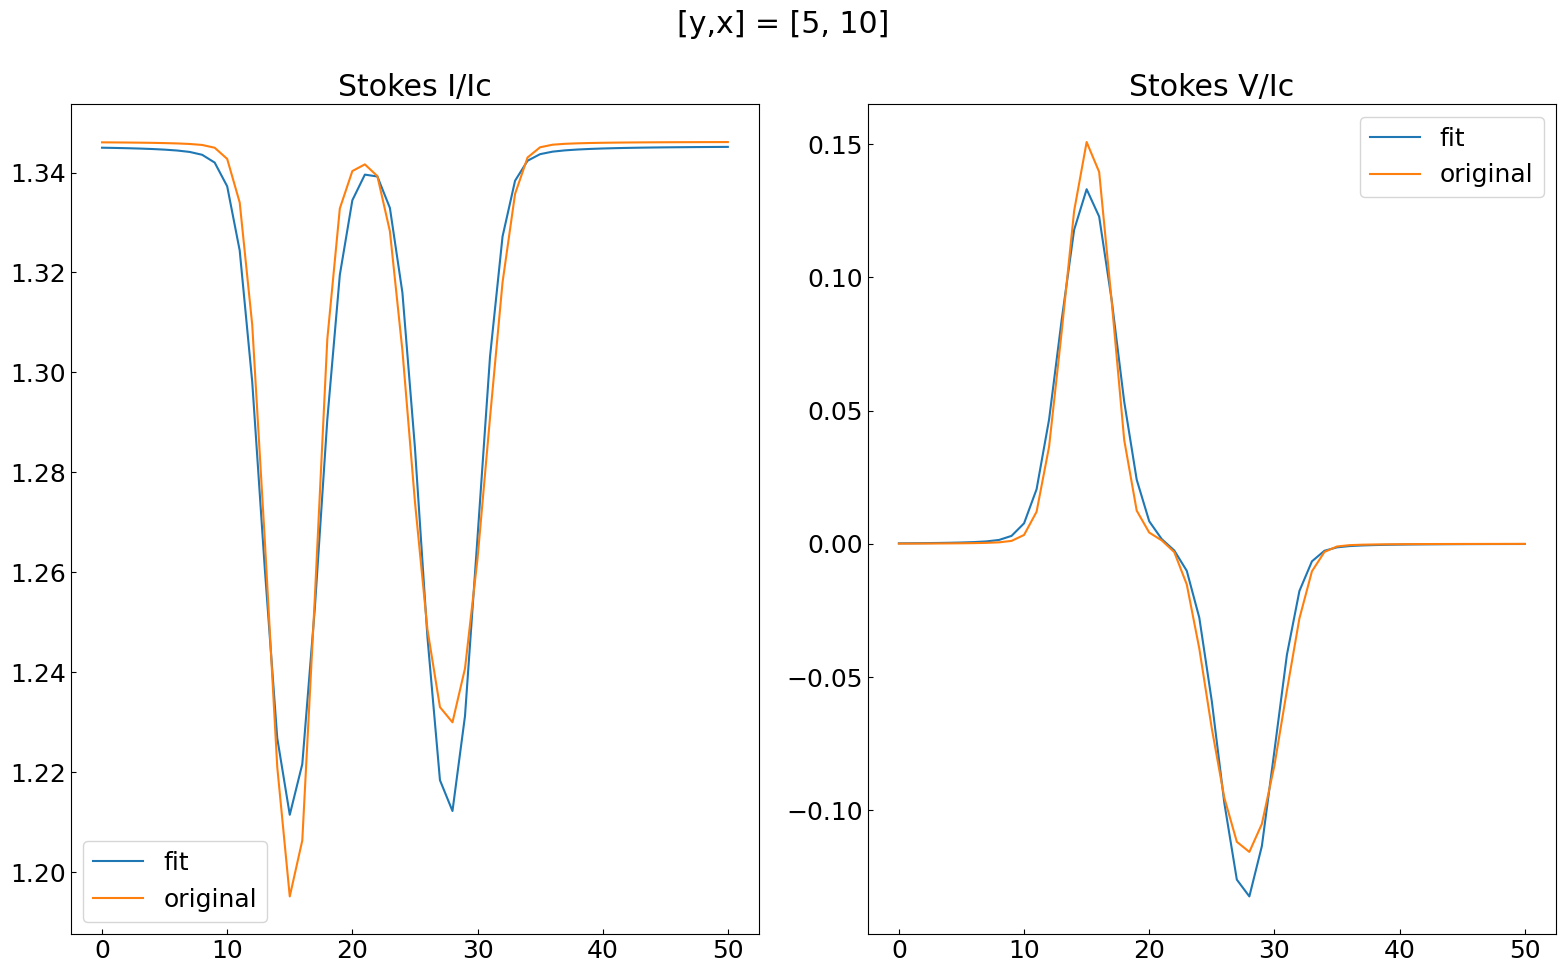

In [14]:
plot_stokes_fit(stokes[...,100:151]/Ic, fitted_stokes,5,10)

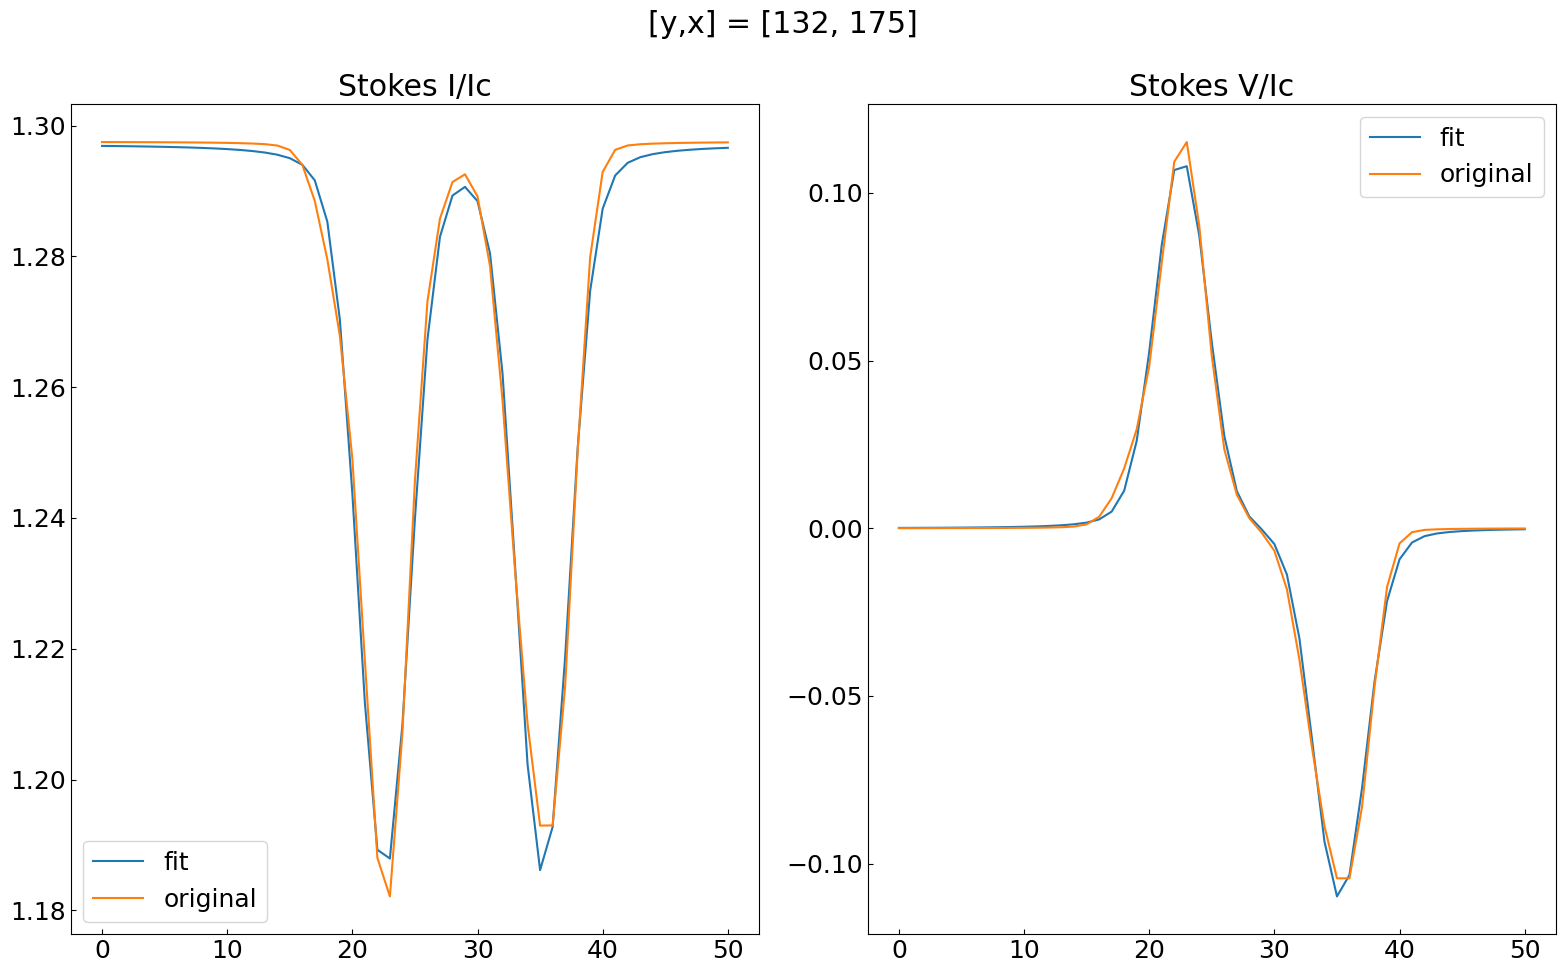

In [15]:
plot_stokes_fit(stokes[...,100:151]/Ic, fitted_stokes,132,175)

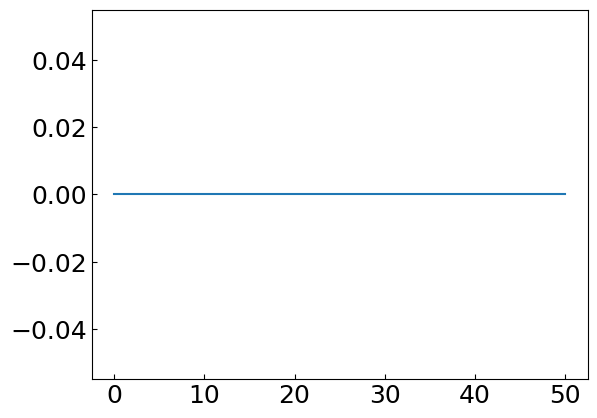

In [42]:
plt.plot(range(51),Q_100)

Weight avg:  1035.0


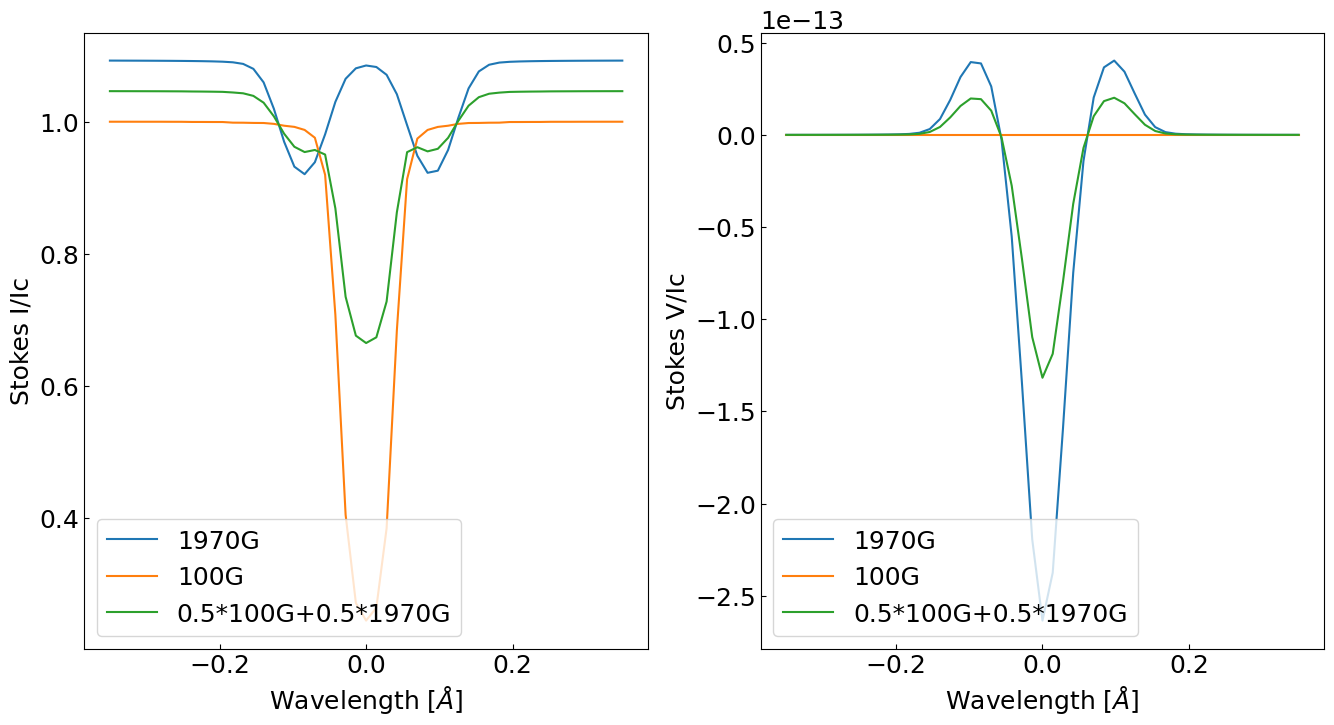

In [41]:
I_big = np.roll(fitted_stokes[268,141,0,:],1)
Q_big = np.roll(fitted_stokes[268,141,1,:],1)
U_big = np.roll(fitted_stokes[268,141,2,:],1)
V_big = np.roll(fitted_stokes[268,141,3,:],1)
plot_diff_x(0.5, I_big, Q_big, I_100, Q_100, big_B = 1970, small_B = 100)

Weight avg:  1035.0


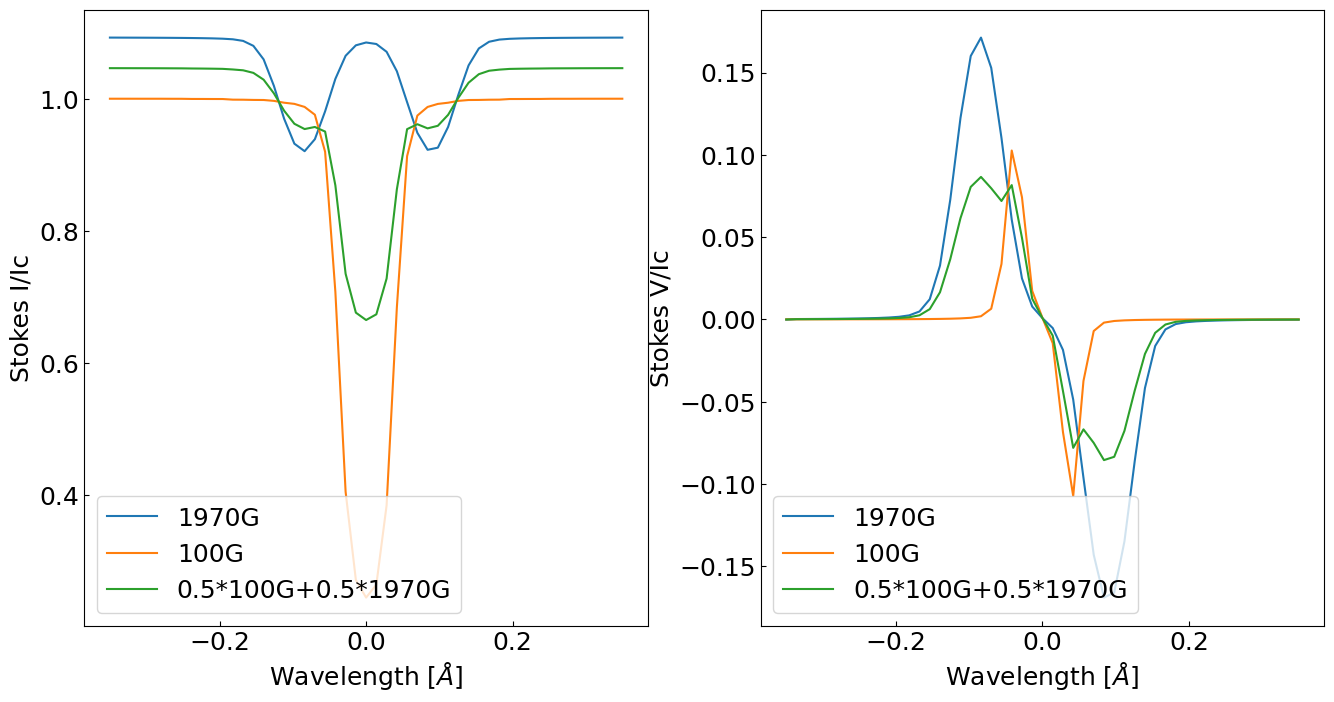

In [32]:
I_big = np.roll(fitted_stokes[268,141,0,:],1)
V_big = np.roll(fitted_stokes[268,141,3,:],1)
plot_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 1970, small_B = 100)

Weight avg:  1044.0


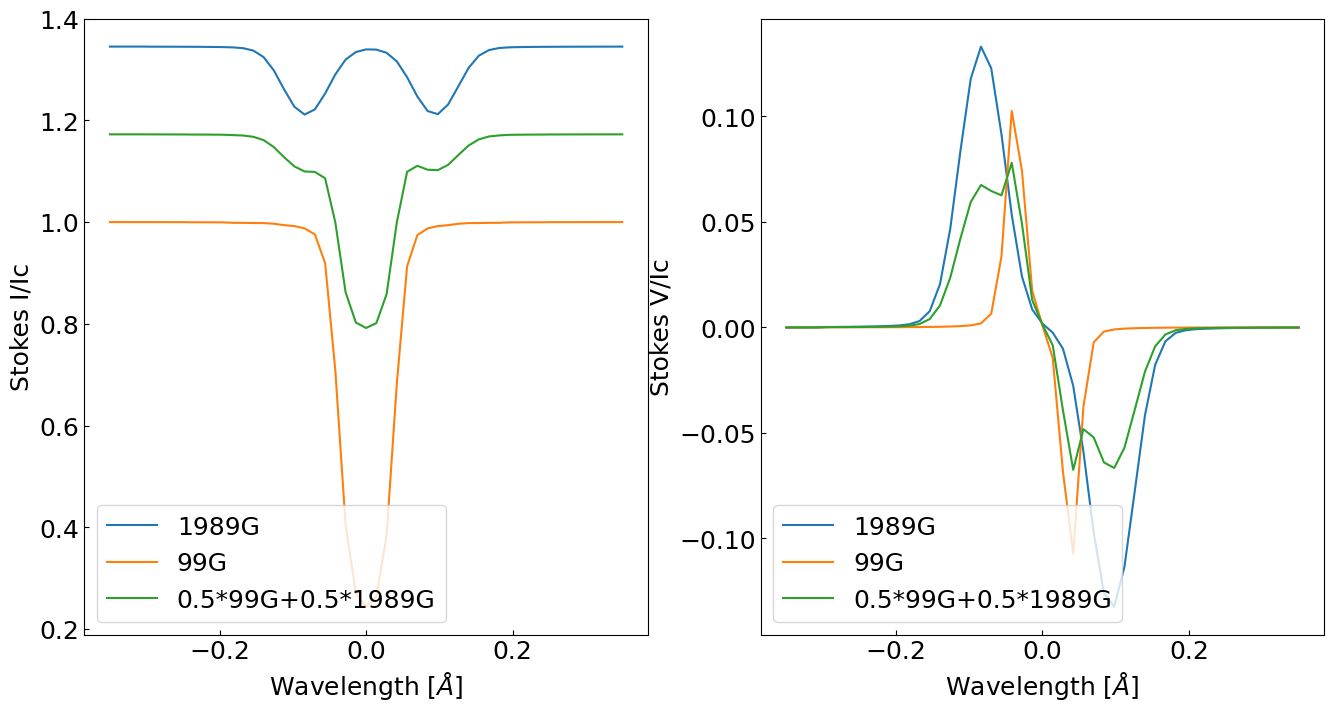

In [16]:
I_big = np.roll(fitted_stokes[5,10,0,:],4)
V_big = np.roll(fitted_stokes[5,10,3,:],4)
plot_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 1989, small_B = 99)

In [17]:
test_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 1989, small_B = 99)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


(1044.0, 205.77068304868982)

In [29]:
test_diff_x(0.5, I_big, V_big, I_100, V_100, big_B = 1989, small_B = 99)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


(1044.0, 205.77068304868982)

In [30]:
blosl = []
weighted = []
for i in np.linspace(0,1,100):
    w,b=test_diff_x(i,I_big, V_big, I_100, V_100, big_B = 1989, small_B = 99)
    weighted.append(w)
    blosl.append(b)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/
Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/

(0.0, 2000.0)

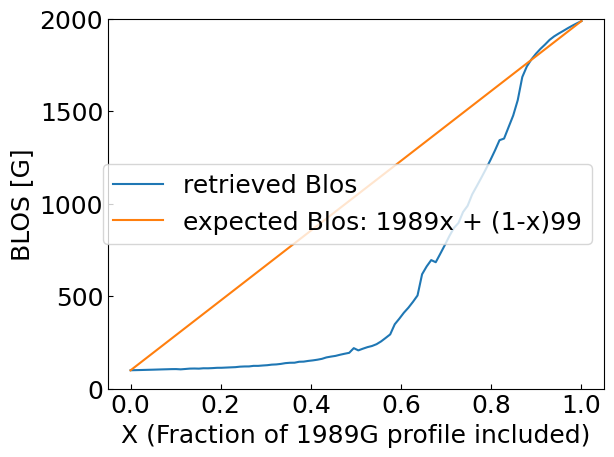

In [31]:
plt.figure()
plt.plot(np.linspace(0,1,100), blosl, label='retrieved Blos')
plt.plot(np.linspace(0,1,100), weighted, label='expected Blos: 1989x + (1-x)99')
plt.xlabel("X (Fraction of 1989G profile included)")
plt.ylabel("BLOS [G]")
plt.legend()
plt.ylim(0,2000)

In [18]:
def get_fitted_profiles_from_comb(comb, dlambda, refwv=6173.341, niter=15):
    num_points = int(2*1000*dlambda/(14) + 1.0)
    wavelengths = np.linspace(refwv-dlambda,refwv+dlambda,num_points)
    
    res = run_cmilos(comb, wavelengths, "CE+RTE", options=[num_points,niter], \
                     out_dir='./', loc='cmilos_1551/', synthesis=0)
    
    return res, run_new_cmilos_syn(res, wavelengths, out_dir='./', niter=15)

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


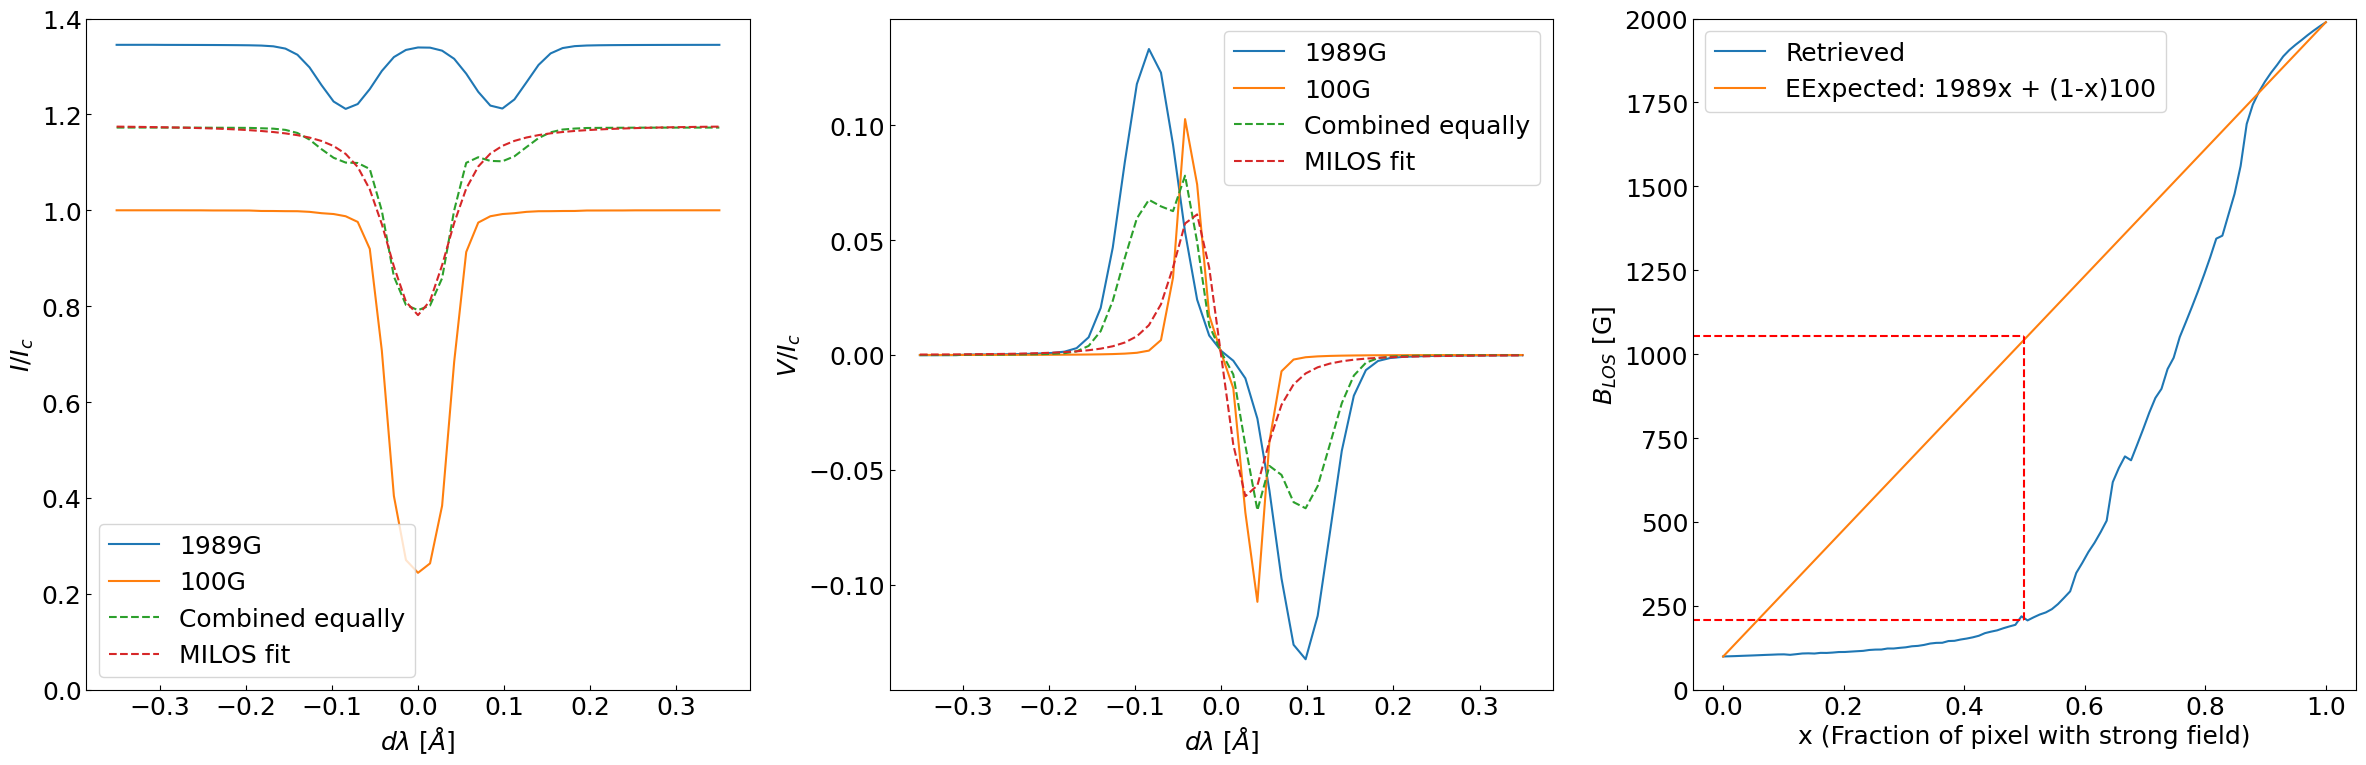

In [33]:
I_big = np.roll(fitted_stokes[5,10,0,:],4)
V_big = np.roll(fitted_stokes[5,10,3,:],4)

I = I_100
v = V_100

x = 0.5

big_B = 1989
small_B = 100

comb_I = x*(I_big) + (1-x)*I
comb_v = x*(V_big) + (1-x)*v

comb_stokes = np.zeros((1,1,4,51))
comb_stokes[:,:,0,:] = comb_I
comb_stokes[:,:,3,:] = comb_v

refwv=6173.341
dlambda=0.35
num_points=51

_, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=15)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(132)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(133)
plt.plot(np.linspace(0,1,100), blosl, label='Retrieved')
plt.plot(np.linspace(0,1,100), weighted, label='EExpected: 1989x + (1-x)100')
plt.axvline(x=0.5,ymin = blosl[50]/2000, ymax = weighted[50]/2000, linestyle = '--', color='red')
plt.axhline(y=blosl[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
plt.axhline(y=weighted[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
plt.xlabel("x (Fraction of pixel with strong field)")
plt.ylabel(r"$B_{LOS}$ [G]")
plt.legend()
plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
array([6172.991, 6173.005, 6173.019, 6173.033, 6173.047, 6173.061,
       6173.075, 6173.089, 6173.103, 6173.117, 6173.131, 6173.145,
       6173.159, 6173.173, 6173.187, 6173.201, 6173.215, 6173.229,
       6173.243, 6173.257, 6173.271, 6173.285, 6173.299, 6173.313,
       6173.327, 6173.341, 6173.355, 6173.369, 6173.383, 6173.397,
       6173.411, 6173.425, 6173.439, 6173.453, 6173.467, 6173.481,
       6173.495, 6173.509, 6173.523, 6173.537, 6173.551, 6173.565,
       6173.579, 6173.593, 6173.607, 6173.621, 6173.635, 6173.649,
       6173.663, 6173.677, 6173.691])

np.linspace(-0.35+6173.341,6173.341+0.35,51)

In [23]:
np.linspace(-dlambda+6173.341,6173.341+dlambda,num_points)

array([6172.991, 6173.005, 6173.019, 6173.033, 6173.047, 6173.061,
       6173.075, 6173.089, 6173.103, 6173.117, 6173.131, 6173.145,
       6173.159, 6173.173, 6173.187, 6173.201, 6173.215, 6173.229,
       6173.243, 6173.257, 6173.271, 6173.285, 6173.299, 6173.313,
       6173.327, 6173.341, 6173.355, 6173.369, 6173.383, 6173.397,
       6173.411, 6173.425, 6173.439, 6173.453, 6173.467, 6173.481,
       6173.495, 6173.509, 6173.523, 6173.537, 6173.551, 6173.565,
       6173.579, 6173.593, 6173.607, 6173.621, 6173.635, 6173.649,
       6173.663, 6173.677, 6173.691])

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


NameError: name 'blosl_5250' is not defined

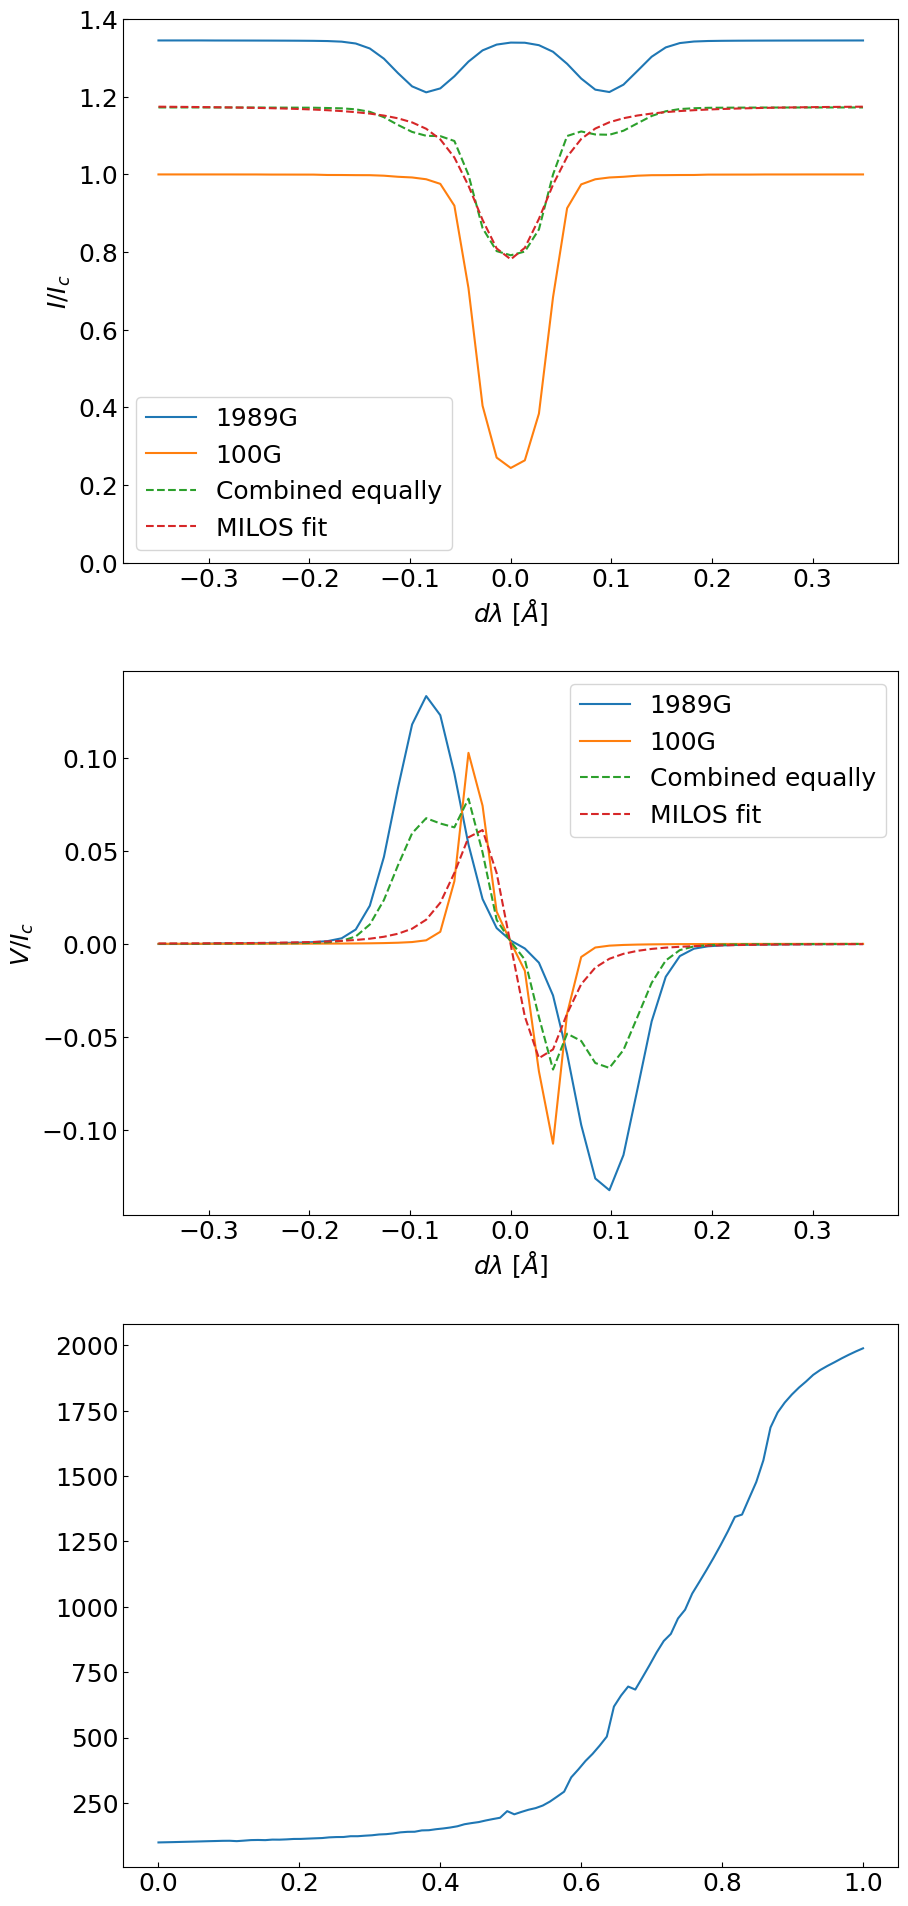

In [34]:
I_big = np.roll(fitted_stokes[5,10,0,:],4)
V_big = np.roll(fitted_stokes[5,10,3,:],4)

I = I_100
v = V_100

x = 0.5

big_B = 1989
small_B = 100

comb_I = x*(I_big) + (1-x)*I
comb_v = x*(V_big) + (1-x)*v

comb_stokes = np.zeros((1,1,4,51))
comb_stokes[:,:,0,:] = comb_I
comb_stokes[:,:,3,:] = comb_v

refwv=6173.341
dlambda=0.35
num_points=51

_, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=15)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(10,24))
plt.subplot(311)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(312)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(313)
plt.plot(np.linspace(0,1,100), blosl, label=r'Inferred ($6173.3\;\AA)$')
plt.plot(np.linspace(0,1,100), blosl_5250, label=r'Inferred ($5250.2\;\AA)$')
plt.plot(np.linspace(0,1,100), weighted, label='Expected: 1989x + (1-x)100', color='black', linestyle='--')
plt.axvline(x=0.5,ymin = blosl[50]/2000, ymax = weighted[50]/2000, linestyle = '--', color='red')
plt.axhline(y=blosl[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
plt.axhline(y=weighted[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
plt.xlabel("x (Fraction of pixel with strong field)")
plt.ylabel(r"$B_{LOS}$ [G]")
plt.legend()
plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G_portrait_5250.png', bbox_inches='tight', dpi=300)
plt.show()

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


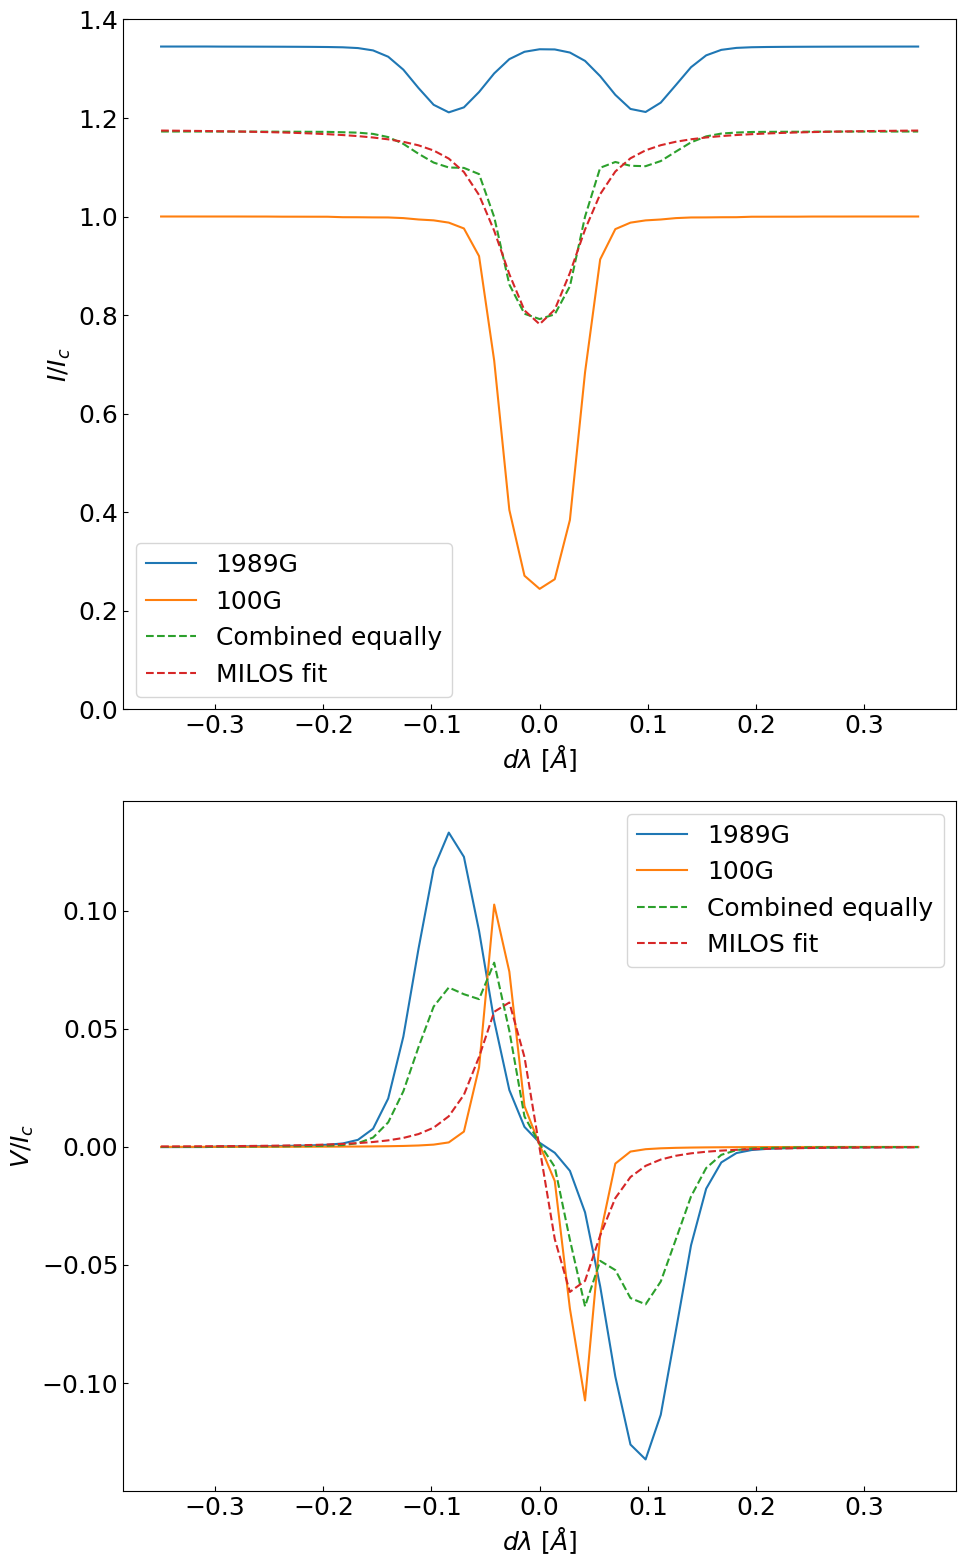

In [13]:
I_big = np.roll(fitted_stokes[5,10,0,:],4)
V_big = np.roll(fitted_stokes[5,10,3,:],4)

I = I_100
v = V_100

x = 0.5

big_B = 1989
small_B = 100

comb_I = x*(I_big) + (1-x)*I
comb_v = x*(V_big) + (1-x)*v

comb_stokes = np.zeros((1,1,4,51))
comb_stokes[:,:,0,:] = comb_I
comb_stokes[:,:,3,:] = comb_v

refwv=6173.341
dlambda=0.35
num_points=51

_, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=15)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(10,16))
plt.subplot(211)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(212)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
# plt.subplot(313)
# plt.plot(np.linspace(0,1,100), blosl, label=r'Inferred ($6173.3\;\AA)$')
# plt.plot(np.linspace(0,1,100), blosl_5250, label=r'Inferred ($5250.2\;\AA)$')
# plt.plot(np.linspace(0,1,100), weighted, label='Expected: 1989x + (1-x)100', color='black', linestyle='--')
# plt.axvline(x=0.5,ymin = blosl[50]/2000, ymax = weighted[50]/2000, linestyle = '--', color='red')
# plt.axhline(y=blosl[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
# plt.axhline(y=weighted[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
# plt.xlabel("x (Fraction of pixel with strong field)")
# plt.ylabel(r"$B_{LOS}$ [G]")
# plt.legend()
# plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G_portrait_noinferred.png', bbox_inches='tight', dpi=300)
plt.show()

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_1551/


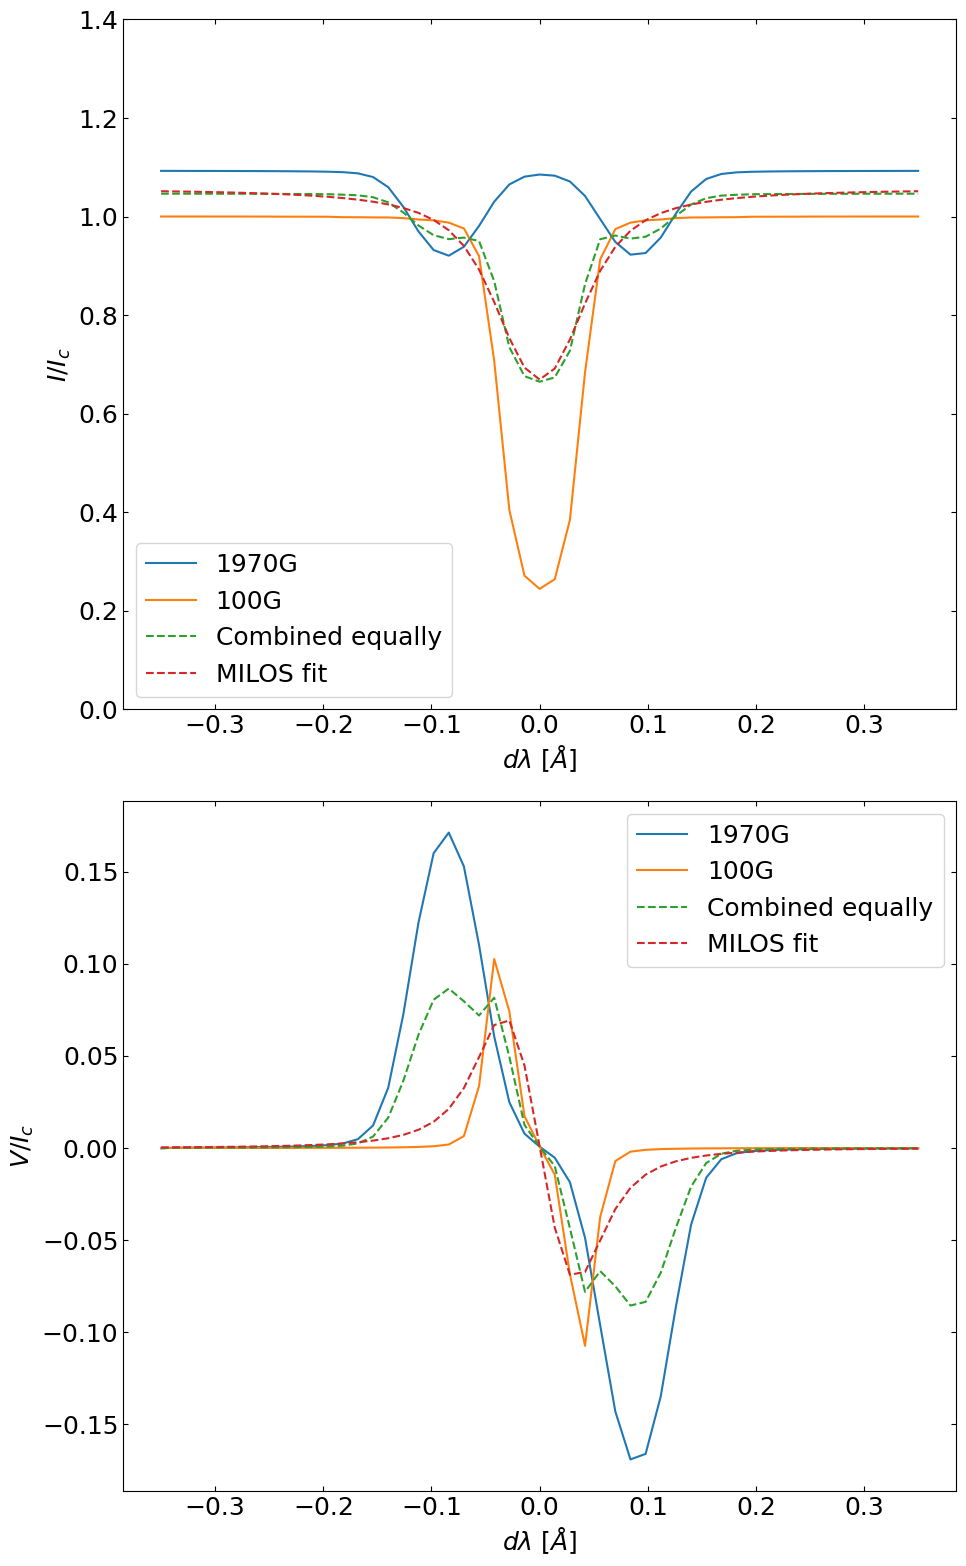

In [25]:
#with Q,U

I_big = np.roll(fitted_stokes[268,141,0,:],1)
Q_big = np.roll(fitted_stokes[268,141,1,:],1)
U_big = np.roll(fitted_stokes[268,141,2,:],1)
V_big = np.roll(fitted_stokes[268,141,3,:],1)

I = I_100
q = Q_100
u = U_100
v = V_100

big_B = 1970
small_B = 100

x = 0.5

comb_I = x*(I_big) + (1-x)*I
comb_v = x*(V_big) + (1-x)*v
comb_q = x*(Q_big) + (1-x)*q
comb_u = x*(U_big) + (1-x)*u

comb_stokes = np.zeros((1,1,4,51))
comb_stokes[:,:,0,:] = comb_I
comb_stokes[:,:,3,:] = comb_v
comb_stokes[:,:,1,:] = comb_q
comb_stokes[:,:,2,:] = comb_u

refwv=6173.341
dlambda=0.35
num_points=51

res, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=50)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(10,16))
plt.subplot(211)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.tick_params(top=True, bottom=True, left=True, right=True, labeltop=False, labelbottom=True, direction="in")
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(212)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.tick_params(top=True, bottom=True, left=True, right=True, labeltop=False, labelbottom=True, direction="in")
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.tight_layout()
plt.savefig('./plots/strong_weak_2000G_1551_ticks.png', bbox_inches='tight', dpi=300)
plt.show()

In [35]:
res[2,:,:]*np.cos(res[3,:,:]/180*np.pi)

array([[274.261643]])

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_1551/


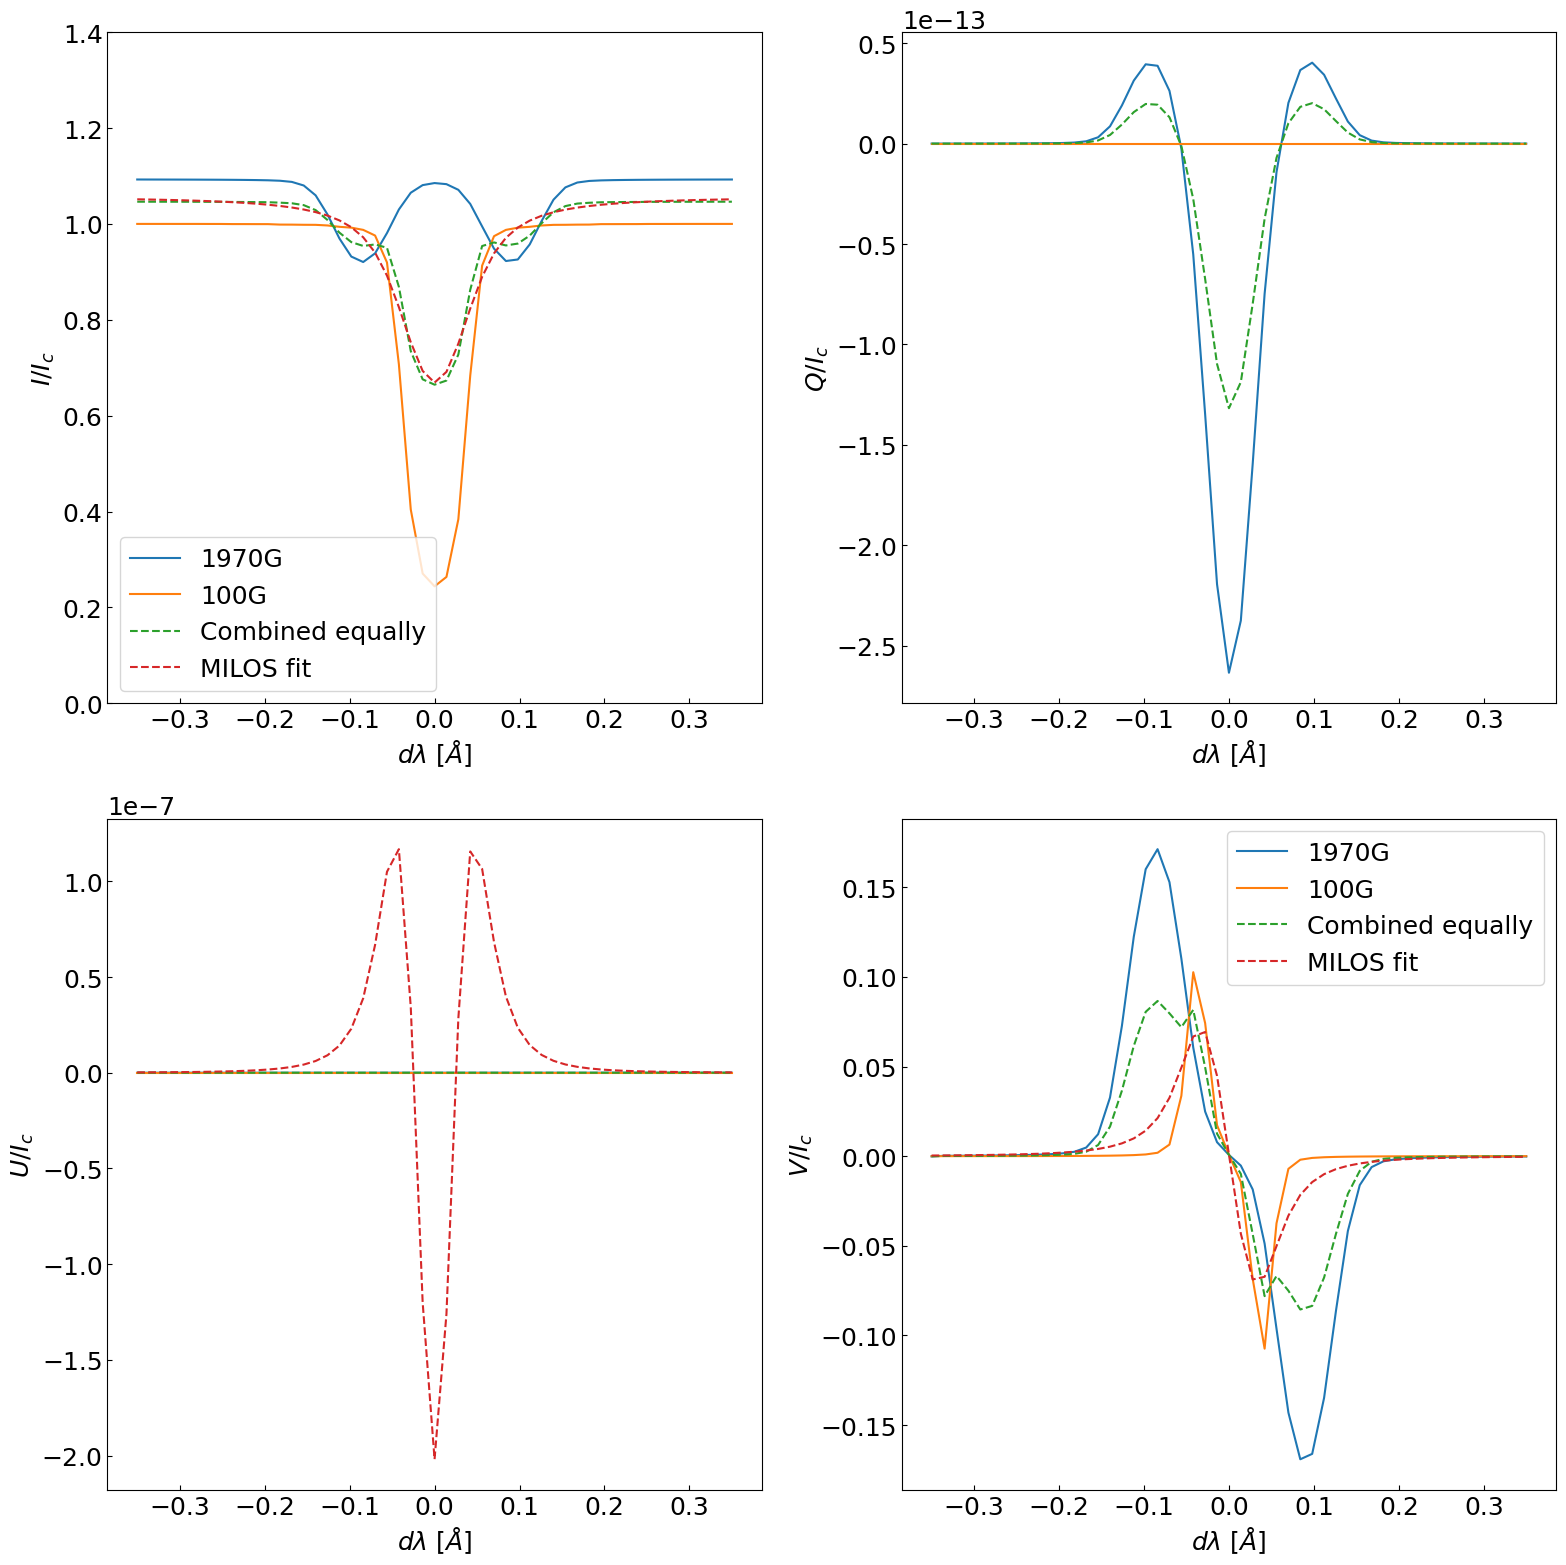

In [33]:
refwv=6173.341
dlambda=0.35
num_points=51

_, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=15)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(222)
plt.plot(waves,Q_big,label=f'{big_B}G')
plt.plot(waves,q,label=f'{small_B}G')
plt.plot(waves,comb_q,'--',label='Combined equally')
#plt.plot(waves,fitted_comb[0,0,1,:],'--',label='MILOS fit')
#plt.legend(loc='upper right')
plt.ylabel(r'$Q/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(223)
plt.plot(waves,U_big,label=f'{big_B}G')
plt.plot(waves,u,label=f'{small_B}G')
plt.plot(waves,comb_u,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,2,:],'--',label='MILOS fit')
#plt.legend(loc='upper right')
plt.ylabel(r'$U/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(224)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G_portrait_noinferred.png', bbox_inches='tight', dpi=300)
plt.show()

In [13]:
comb_stokes.T.shape

(51, 4, 1, 1)

In [20]:
data = np.moveaxis(comb_stokes,(0,1,2,3),(3,2,1,0))
data.shape

(51, 4, 1, 1)

In [21]:
data_array = np.zeros((51,4,3,1))
data_array[:,:,0,0] = data[:,:,0,0]

In [22]:
data_array[:,0,1,0] = I_100
data_array[:,1,1,0] = Q_100
data_array[:,2,1,0] = U_100
data_array[:,3,1,0] = V_100

In [23]:
data_array[:,0,2,0] = I_big
data_array[:,1,2,0] = Q_big
data_array[:,2,2,0] = U_big
data_array[:,3,2,0] = V_big

In [22]:
np.linspace(-0.35+6173.341,0.35+6173.341,51).shape

(51,)

In [25]:
from astropy.io import fits
primary_hdu=fits.PrimaryHDU(data=data_array)
hdr = primary_hdu.header
hdr['NAXIS1'] = 51
hdr['NAXIS2'] = 4
hdr['NAXIS3'] = 3
hdr['NAXIS4'] = 1
extension_hdu = fits.ImageHDU(np.linspace(-0.35+6173.341,0.35+6173.341,51))
extension_hdu.header['NAXIS']=51
hdul=fits.HDUList([primary_hdu,extension_hdu])
hdul.writeto('./combined_profile_3.fits',overwrite=True)

In [29]:
with fits.open('./combined_profile_3.fits') as hdul:
    print(hdul[1].data)

[6172.991 6173.005 6173.019 6173.033 6173.047 6173.061 6173.075 6173.089
 6173.103 6173.117 6173.131 6173.145 6173.159 6173.173 6173.187 6173.201
 6173.215 6173.229 6173.243 6173.257 6173.271 6173.285 6173.299 6173.313
 6173.327 6173.341 6173.355 6173.369 6173.383 6173.397 6173.411 6173.425
 6173.439 6173.453 6173.467 6173.481 6173.495 6173.509 6173.523 6173.537
 6173.551 6173.565 6173.579 6173.593 6173.607 6173.621 6173.635 6173.649
 6173.663 6173.677 6173.691]


Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos_1551/


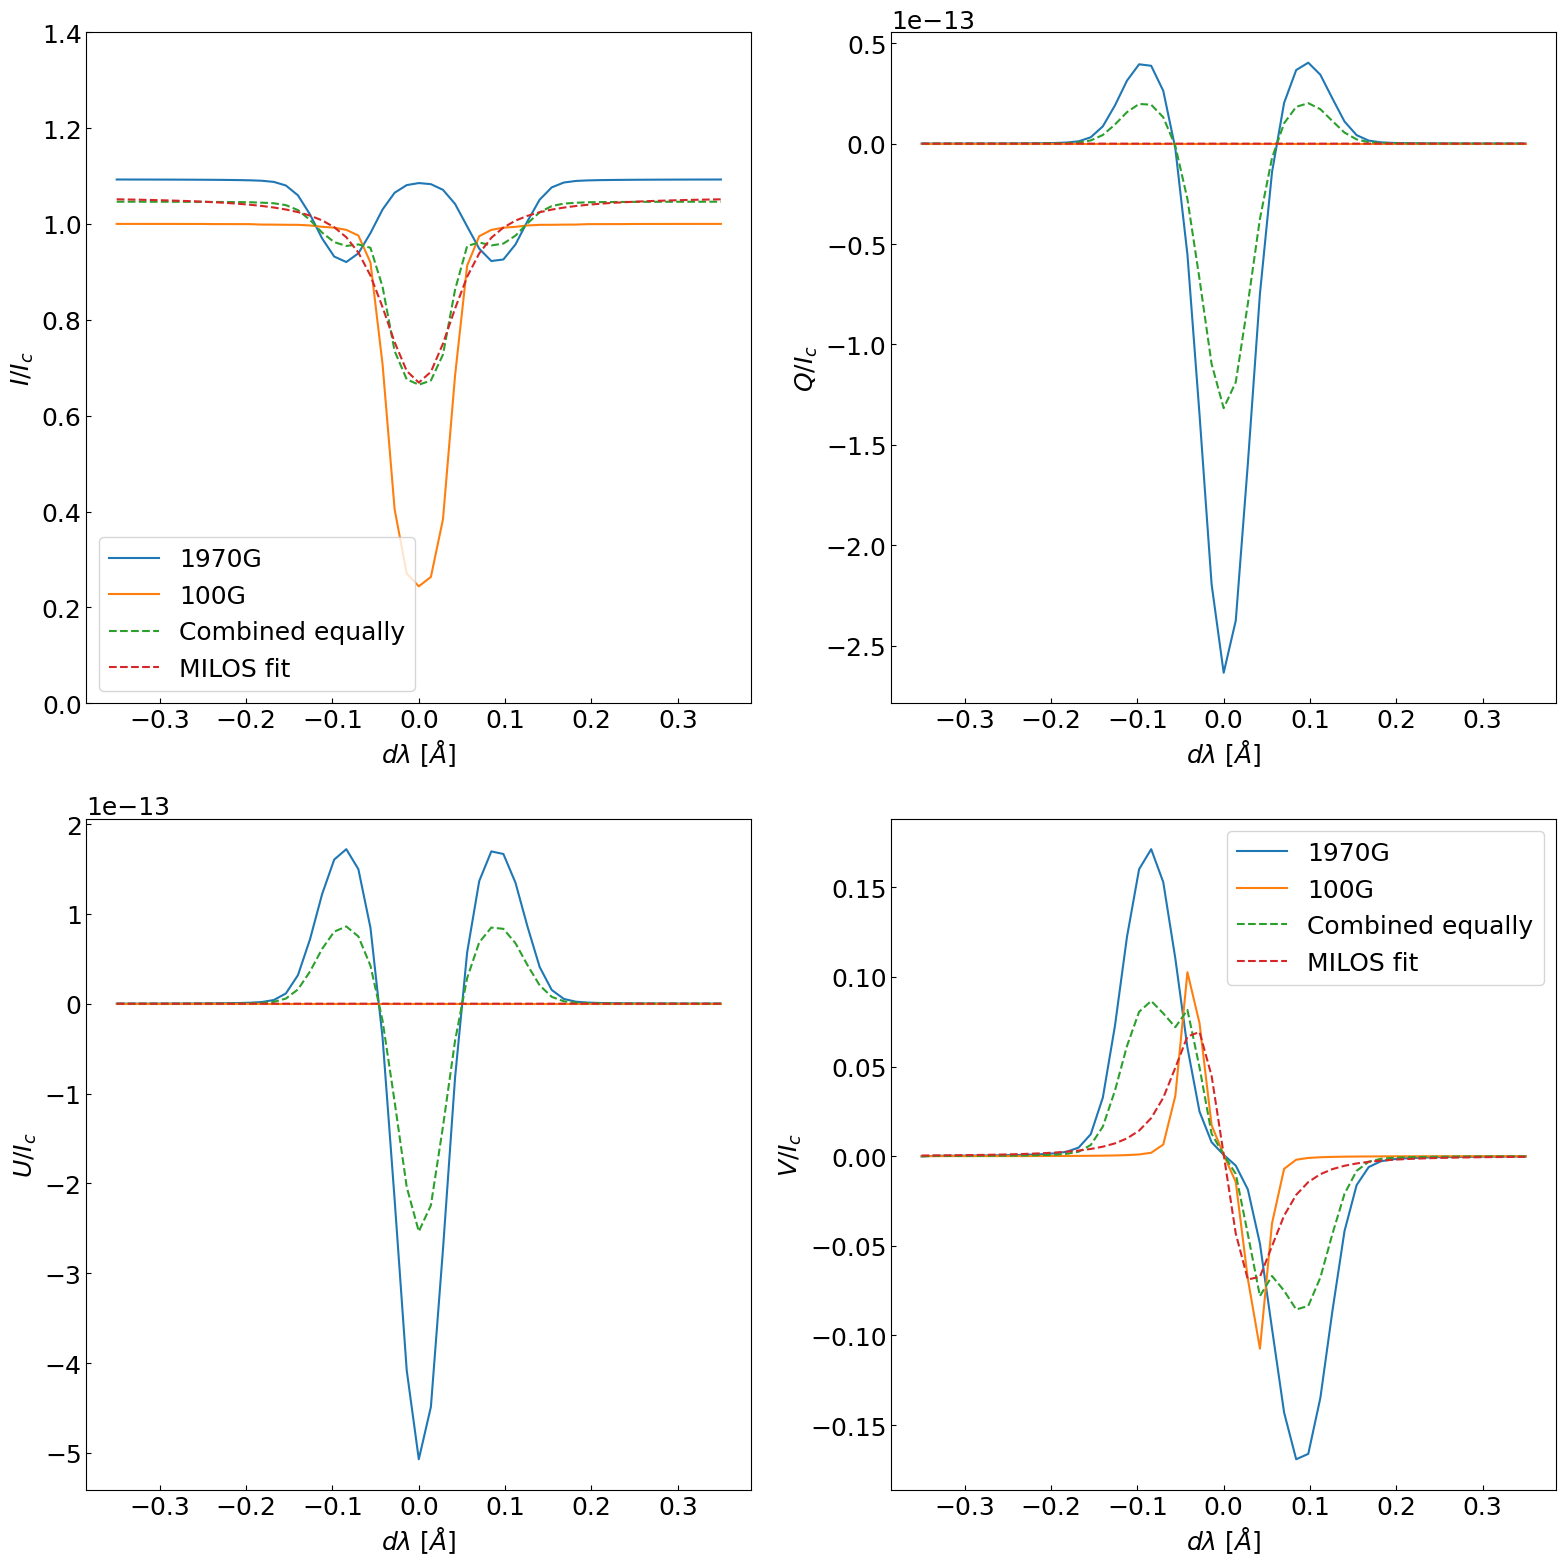

In [31]:
refwv=6173.341
dlambda=0.35
num_points=51

_, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=50)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(222)
plt.plot(waves,Q_big,label=f'{big_B}G')
plt.plot(waves,q,label=f'{small_B}G')
plt.plot(waves,comb_q,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,1,:],'--',label='MILOS fit')
#plt.legend(loc='upper right')
plt.ylabel(r'$Q/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(223)
plt.plot(waves,U_big,label=f'{big_B}G')
plt.plot(waves,u,label=f'{small_B}G')
plt.plot(waves,comb_u,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,2,:],'--',label='MILOS fit')
#plt.legend(loc='upper right')
plt.ylabel(r'$U/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(224)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')


# plt.subplot(313)
# plt.plot(np.linspace(0,1,100), blosl, label=r'Inferred ($6173.3\;\AA)$')
# plt.plot(np.linspace(0,1,100), blosl_5250, label=r'Inferred ($5250.2\;\AA)$')
# plt.plot(np.linspace(0,1,100), weighted, label='Expected: 1989x + (1-x)100', color='black', linestyle='--')
# plt.axvline(x=0.5,ymin = blosl[50]/2000, ymax = weighted[50]/2000, linestyle = '--', color='red')
# plt.axhline(y=blosl[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
# plt.axhline(y=weighted[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
# plt.xlabel("x (Fraction of pixel with strong field)")
# plt.ylabel(r"$B_{LOS}$ [G]")
# plt.legend()
# plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G_portrait_noinferred.png', bbox_inches='tight', dpi=300)
plt.show()

Cmilos executable located at: /scratch/slam/sinjan/true_flux_project/cmilos/


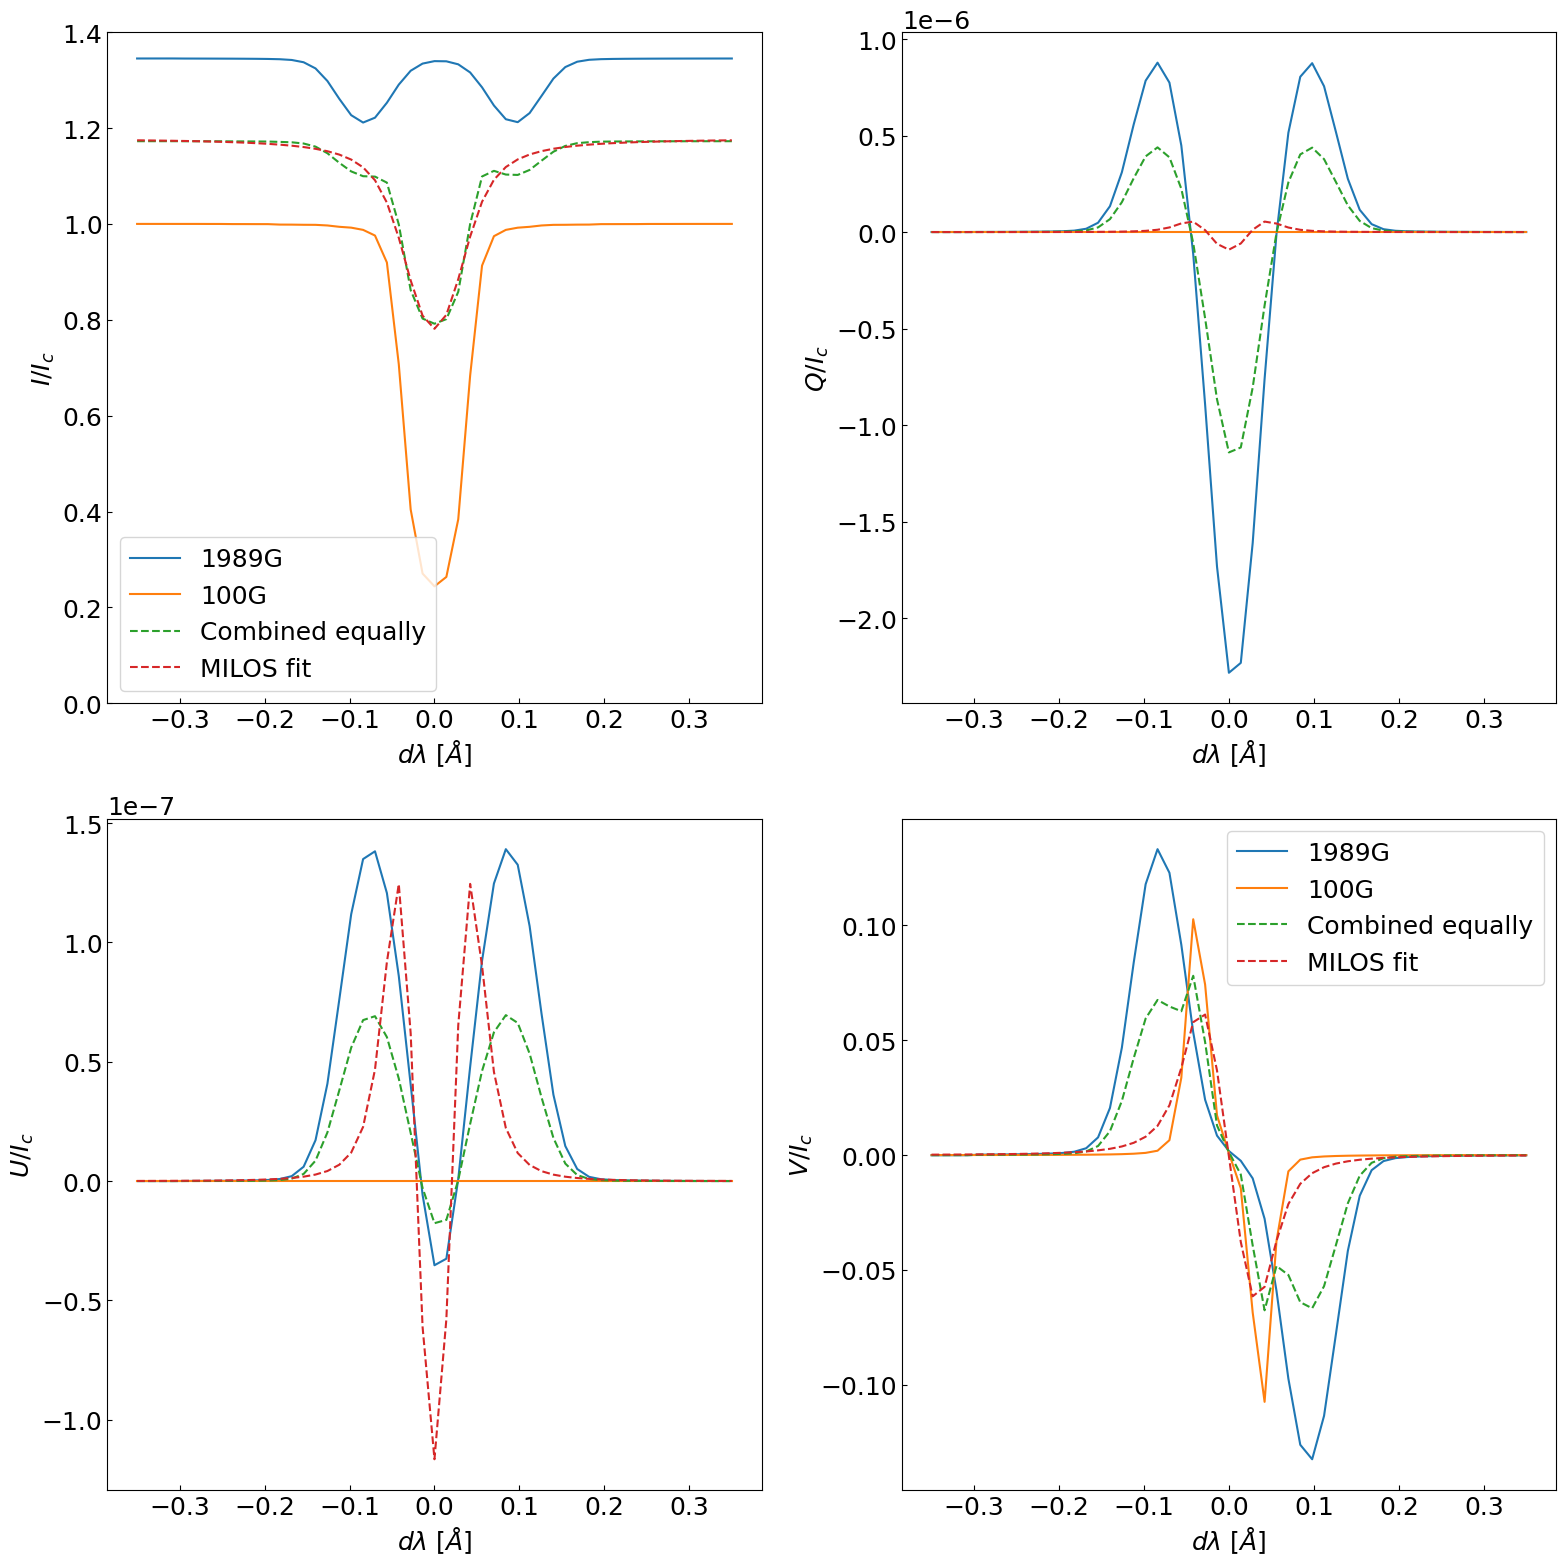

In [40]:
refwv=6173.341
dlambda=0.35
num_points=51

res, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=15)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(222)
plt.plot(waves,Q_big,label=f'{big_B}G')
plt.plot(waves,q,label=f'{small_B}G')
plt.plot(waves,comb_q,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,1,:],'--',label='MILOS fit')
#plt.legend(loc='upper right')
plt.ylabel(r'$Q/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(223)
plt.plot(waves,U_big,label=f'{big_B}G')
plt.plot(waves,u,label=f'{small_B}G')
plt.plot(waves,comb_u,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,2,:],'--',label='MILOS fit')
#plt.legend(loc='upper right')
plt.ylabel(r'$U/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')

plt.subplot(224)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')


# plt.subplot(313)
# plt.plot(np.linspace(0,1,100), blosl, label=r'Inferred ($6173.3\;\AA)$')
# plt.plot(np.linspace(0,1,100), blosl_5250, label=r'Inferred ($5250.2\;\AA)$')
# plt.plot(np.linspace(0,1,100), weighted, label='Expected: 1989x + (1-x)100', color='black', linestyle='--')
# plt.axvline(x=0.5,ymin = blosl[50]/2000, ymax = weighted[50]/2000, linestyle = '--', color='red')
# plt.axhline(y=blosl[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
# plt.axhline(y=weighted[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
# plt.xlabel("x (Fraction of pixel with strong field)")
# plt.ylabel(r"$B_{LOS}$ [G]")
# plt.legend()
# plt.ylim(0,2000)
plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G_portrait_noinferred.png', bbox_inches='tight', dpi=300)
plt.show()

In [41]:
res[2,:,:]*np.cos(res[3,:,:]/180*np.pi)

array([[204.49585106]])

In [ ]:
# 195 with eqweights, but fitted q and u much too strong
# 173 with 1,10,10,1 and q and u fits ok
# 204 with 1,4,5,1

# 1000G plot

In [ ]:
I_big = np.roll(fitted_stokes[279,125,0,:],0)
V_big = np.roll(fitted_stokes[279,125,3,:],0)

I = I_100
v = V_100

x = 0.5

big_B = 1000
small_B = 100

In [ ]:
blosl = []
weighted = []
for i in np.linspace(0,1,100):
    w,b=test_diff_x(i,I_big, V_big, I_100, V_100, big_B, small_B)
    weighted.append(w)
    blosl.append(b)

In [ ]:
blosl

In [ ]:
comb_I = x*(I_big) + (1-x)*I
comb_v = x*(V_big) + (1-x)*v

comb_stokes = np.zeros((1,1,4,51))
comb_stokes[:,:,0,:] = comb_I
comb_stokes[:,:,3,:] = comb_v

refwv=6173.341
dlambda=0.35
num_points=51

_, fitted_comb = get_fitted_profiles_from_comb(comb_stokes, dlambda, refwv=6173.341, niter=15)

waves = np.linspace(-dlambda,dlambda,num_points)
plt.figure(figsize=(24,8))
plt.subplot(131)
plt.plot(waves,I_big,label=f'{big_B}G')
plt.plot(waves,I,label=f'{small_B}G')
plt.plot(waves,comb_I,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,0,:],'--',label='MILOS fit')
plt.ylim(0,1.4)
plt.legend()
plt.ylabel('$I/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(132)
plt.plot(waves,V_big,label=f'{big_B}G')
plt.plot(waves,v,label=f'{small_B}G')
plt.plot(waves,comb_v,'--',label='Combined equally')
plt.plot(waves,fitted_comb[0,0,3,:],'--',label='MILOS fit')
plt.legend(loc='upper right')
plt.ylabel(r'$V/I_c$')
plt.xlabel(r'$d\lambda$ [$\AA$]')
plt.subplot(133)
plt.plot(np.linspace(0,1,100), blosl, label='Retrieved')
plt.plot(np.linspace(0,1,100), weighted, label='EExpected: 1989x + (1-x)100')
#plt.axvline(x=0.5,ymin = blosl[50]/big_B, ymax = weighted[50]//big_B, linestyle = '--', color='red')
#plt.axhline(y=blosl[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
#plt.axhline(y=weighted[50],xmin = -0.5, xmax = 0.5, linestyle='--', color='red')
plt.xlabel("x (Fraction of pixel with strong field)")
plt.ylabel(r"$B_{LOS}$ [G]")
plt.legend()
plt.ylim(0,big_B)
plt.tight_layout()
#plt.savefig('./plots/strong_weak_2000G.png', bbox_inches='tight', dpi=300)
plt.show()

# 5250

- repeat the process for a 100G and 2000G pixel (maybe select the same pixel) set Q and U to 0 so CMILOS doesn't fail
- add a curve to the final subplot to see if there is a different effect

In [17]:
ang='00'
stokes_5250 = create_stokes_profiles('ngrey_200G_5250_noneigh',ang,'200000',inst='MURaM', default_dir='/data/slam/sinjan/spinor_fwd/')
res_5250, fitted_stokes_5250 = get_fitted_profiles_from_stokes_5250(stokes_5250, 0.35, refwv=5250.208, niter=15)

--------START---------
Folder:  ngrey_200G_5250_noneigh
Snapshot:  200000
Angle:  00
Remainder mode:  round
inst_y:  288.0
inst_x: : 288.0
-------PREP END--------
non contiguous vector
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]


ValueError: too many values to unpack (expected 3)

In [ ]:
Ic_5250 = stokes_5250[:,:,0,100].mean() 

In [ ]:
b1 = res_5250[2,:,:]*np.cos(res_5250[3,:,:]/180*np.pi)
np.max(b1)

In [ ]:
np.mean(b1)

In [ ]:
plt.figure()
plt.imshow(b1,origin="lower")
plt.colorbar()
plt.show()

In [ ]:
inc_5250 = res_5250[3,:,:]
vel_5250 = res_5250[6,:,:]
idx_2000G_5250 = np.where((blos>1900) & (blos<2100) & (inc_5250<1.0) & (vel_5250 < 0.05))
print(blos[idx_2000G_5250])
print(inc_5250[idx_2000G_5250])
print(vel_5250[idx_2000G_5250])
print(idx_2000G_5250)

In [ ]:
plot_stokes_fit(stokes_5250[...,100:151]/Ic_5250, fitted_stokes_5250,287,9)

In [ ]:
stokes_100_5250 = fits.getdata("/data/slam/sinjan/1d_100G_syn/5250_masi_theta00/inverted_profs.1.fits")[:,:,[0,2,3,1],:].mean(axis=(0,1))
stokes_100_5250 = np.expand_dims(stokes_100_5250,axis=(0,1))
Ic_100_5250 = stokes_100_5250[:,:,0,100].mean()
I_100_5250 = stokes_100_5250[:,:,0,100:151]/Ic_100_5250
V_100_5250 = stokes_100_5250[:,:,3,100:151]/Ic_100_5250

In [ ]:
I_big_5250 = np.roll(fitted_stokes_5250[287,9,0,100:151],0)
V_big_5250 = np.roll(fitted_stokes_5250[287,9,3,100:151],0)
plot_diff_x(0.5, I_big_5250, V_big_5250, I_100_5250, V_100_5250, big_B = 1989, small_B = 99)

In [ ]:
blosl_5250 = []
weighted = []
for i in np.linspace(0,1,100):
    _,bo=test_diff_x_pymilos(i,fitted_stokes_5250[287,9,:,100:151], stokes_100_5250/Ic_100_5250, big_B = 1989, small_B = 99, refwv=5250.208, loc = 'pymilos_5250')
    blosl_5250.append(bo)
    blosl.append(bt)
    weighted.append(w)

In [ ]:
plt.figure(figsize=(14,14))
plt.plot(np.linspace(0,1,100), blosl_5250, label='5250')
plt.plot(np.linspace(0,1,100), blosl_5250_old, label='5250 old')
plt.plot(np.linspace(0,1,100), blosl, label='6173')
plt.plot(np.linspace(0,1,100), weighted, label='expected Blos: 1989x + (1-x)99')
plt.xlabel("X (Fraction of 1989G profile included)")
plt.ylabel("BLOS [G]")
plt.legend()
plt.ylim(0,2000)
#plt.xlim(0,0.4)

In [ ]:
res_test = run_cmilos(np.expand_dims(stokes_5250[287,9,:,100:151],axis=(0,1))/Ic_5250, wavelengths, "CE+RTE", options=[num_points,15], \
                     out_dir='./', loc='cmilos_5250/', synthesis=0)

In [ ]:
res_test[2]

In [ ]:
res_test[3]

In [ ]:
plt.figure(figsize=(14,14))
#plt.plot(np.linspace(0,1,100), blosl_5250, label='5250')
plt.plot(np.linspace(0,1,100), np.array(blosl_5250_old)-np.array(blosl_5250), label='5250 old')
#plt.plot(np.linspace(0,1,100), blosl, label='6173')
#plt.plot(np.linspace(0,1,100), weighted, label='expected Blos: 1989x + (1-x)99')
plt.xlabel("X (Fraction of 1989G profile included)")
plt.ylabel("BLOS [G]")
plt.legend()
#plt.ylim(0,2000)